In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

# Loading the Data

## Finding & Loading Batches of Files with glob

In [2]:
import glob
## Make a filepath query
q = 'Data/2000-2021/final*.csv.gz'
file_list = glob.glob(q, recursive = True)
file_list

['Data/2000-2021\\final_tmdb_data_2000.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2001.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2002.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2003.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2004.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2005.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2006.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2007.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2008.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2009.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2010.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2011.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2012.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2013.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2014.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2015.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2016.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2017.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2018.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2019.csv.gz',
 'Data/2000-2021\\final_tmdb_data_2020.c

In [3]:
## use a list comprehension to load in all files into 1 dataframe
df = pd.concat([pd.read_csv(file, lineterminator = '\n') for file in file_list])
df.head()

imdb_id  adult                     backdrop_path belongs_to_collection  \
0          0    NaN                               NaN                   NaN   
1  tt0113026    0.0  /vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg                   NaN   
2  tt0113092    0.0                               NaN                   NaN   
3  tt0116391    0.0                               NaN                   NaN   
4  tt0118694    0.0  /n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg                   NaN   

       budget                                             genres  \
0         NaN                                                NaN   
1  10000000.0  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...   
2         0.0           [{'id': 878, 'name': 'Science Fiction'}]   
3         0.0  [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
4    150000.0  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   

                               homepage        id original_language  \
0                                   NaN       NaN               NaN   
1                                   NaN   62127.0                en   
2                                   NaN  110977.0                en   
3                                   NaN  442869.0                hi   
4  http://www.wkw-inthemoodforlove.com/     843.0                cn   

    original_title  ...     revenue  runtime  \
0              NaN  ...         NaN      NaN   
1  The Fantasticks  ...         0.0     86.0   
2    For the Cause  ...         0.0    100.0   
3             Gang  ...         0.0    152.0   
4             花樣年華  ...  12854953.0     99.0   

                                    spoken_languages    status  \
0                                                NaN       NaN   
1  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
2  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
3  [{'english_name': 'Hindi', 'iso_639_1': 'hi', ...  Released   
4  [{'english_name': 'Cantonese', 'iso_639_1': 'c...  Released   

                                             tagline                 title  \
0                                                NaN                   NaN   
1      Try to remember the first time magic happened       The Fantasticks   
2       The ultimate showdown on a forbidden planet.         For the Cause   
3                                                NaN                  Gang   
4  Feel the heat, keep the feeling burning, let t...  In the Mood for Love   

   video  vote_average vote_count certification  
0    NaN           NaN        NaN           NaN  
1    0.0           5.4       21.0           NaN  
2    0.0           4.4        7.0           NaN  
3    0.0           0.0        0.0           NaN  
4    0.0           8.1     1868.0            PG  

[5 rows x 26 columns]

In [4]:
# remove ids that are 0  and then reset index
df = df.loc[df['imdb_id']!="0"]
df = df.reset_index(drop=True)
df

imdb_id  adult                     backdrop_path  \
0      tt0113026    0.0  /vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg   
1      tt0113092    0.0                               NaN   
2      tt0116391    0.0                               NaN   
3      tt0118694    0.0  /n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg   
4      tt0118852    0.0                               NaN   
...          ...    ...                               ...   
60125  tt9895024    0.0   /S1kutYyoyuBJKGS0mXxv2fZNbr.jpg   
60126  tt9896876    0.0  /hMvRbT6HOqERhh3K8kXbaLz9LlZ.jpg   
60127  tt9898844    0.0  /q2KFBGyUSzHDhNqXEYv2LqTWVSz.jpg   
60128  tt9900940    0.0  /3jjWLg5bevWqReyVroYqxwVrH0k.jpg   
60129  tt9907782    0.0  /gRTYArznK1MLAq7opC1tYHnTwM3.jpg   

      belongs_to_collection      budget  \
0                       NaN  10000000.0   
1                       NaN         0.0   
2                       NaN         0.0   
3                       NaN    150000.0   
4                       NaN         0.0   
...                     ...         ...   
60125                   NaN         0.0   
60126                   NaN         0.0   
60127                   NaN         0.0   
60128                   NaN         0.0   
60129                   NaN         0.0   

                                                  genres  \
0      [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...   
1               [{'id': 878, 'name': 'Science Fiction'}]   
2      [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
3      [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   
4                          [{'id': 18, 'name': 'Drama'}]   
...                                                  ...   
60125  [{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...   
60126  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
60127                     [{'id': 27, 'name': 'Horror'}]   
60128  [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...   
60129  [{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...   

                                   homepage        id original_language  \
0                                       NaN   62127.0                en   
1                                       NaN  110977.0                en   
2                                       NaN  442869.0                hi   
3      http://www.wkw-inthemoodforlove.com/     843.0                cn   
4                                       NaN   49511.0                en   
...                                     ...       ...               ...   
60125                                   NaN  834443.0                de   
60126                                   NaN  821493.0                en   
60127                                   NaN  870671.0                en   
60128                                   NaN  861294.0                en   
60129                                   NaN  630392.0                en   

                original_title  ...     revenue  runtime  \
0              The Fantasticks  ...         0.0     86.0   
1                For the Cause  ...         0.0    100.0   
2                         Gang  ...         0.0    152.0   
3                         花樣年華  ...  12854953.0     99.0   
4               Chinese Coffee  ...         0.0     99.0   
...                        ...  ...         ...      ...   
60125              Heikos Welt  ...         0.0    118.0   
60126  India Sweets and Spices  ...         0.0    101.0   
60127              The Hunting  ...         0.0     91.0   
60128             The Scrapper  ...         0.0     87.0   
60129               The Cursed  ...   4588389.0    111.0   

                                        spoken_languages    status  \
0      [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
1      [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
2      [{'english_name': 'Hindi', 'iso_639_1': 'hi', ...  Released   
3      [{'english_name': 'Cantonese', 'iso_639_1': 'c...  Released   
4      [{'english_name': 'English', 'iso_639_1': 'en'...  Released

In [5]:
## saving the combined csv to disk
df.to_csv('Data/2000-2021/combined_tmdb_data.csv.gz', compression='gzip', index = False)

## Removing Unnecessary Data

In [6]:
## load the combined csv
df = pd.read_csv('Data/2000-2021/combined_tmdb_data.csv.gz')
df.head()

imdb_id  adult                     backdrop_path belongs_to_collection  \
0  tt0113026    0.0  /vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg                   NaN   
1  tt0113092    0.0                               NaN                   NaN   
2  tt0116391    0.0                               NaN                   NaN   
3  tt0118694    0.0  /n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg                   NaN   
4  tt0118852    0.0                               NaN                   NaN   

       budget                                             genres  \
0  10000000.0  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...   
1         0.0           [{'id': 878, 'name': 'Science Fiction'}]   
2         0.0  [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
3    150000.0  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   
4         0.0                      [{'id': 18, 'name': 'Drama'}]   

                               homepage        id original_language  \
0                                   NaN   62127.0                en   
1                                   NaN  110977.0                en   
2                                   NaN  442869.0                hi   
3  http://www.wkw-inthemoodforlove.com/     843.0                cn   
4                                   NaN   49511.0                en   

    original_title  ...     revenue  runtime  \
0  The Fantasticks  ...         0.0     86.0   
1    For the Cause  ...         0.0    100.0   
2             Gang  ...         0.0    152.0   
3             花樣年華  ...  12854953.0     99.0   
4   Chinese Coffee  ...         0.0     99.0   

                                    spoken_languages    status  \
0  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
1  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
2  [{'english_name': 'Hindi', 'iso_639_1': 'hi', ...  Released   
3  [{'english_name': 'Cantonese', 'iso_639_1': 'c...  Released   
4  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   

                                             tagline                 title  \
0      Try to remember the first time magic happened       The Fantasticks   
1       The ultimate showdown on a forbidden planet.         For the Cause   
2                                                NaN                  Gang   
3  Feel the heat, keep the feeling burning, let t...  In the Mood for Love   
4  There's a fine line between friendship and bet...        Chinese Coffee   

   video  vote_average vote_count certification  
0    0.0           5.4       21.0           NaN  
1    0.0           4.4        7.0           NaN  
2    0.0           0.0        0.0           NaN  
3    0.0           8.1     1868.0            PG  
4    0.0           6.9       46.0             R  

[5 rows x 26 columns]

In [7]:
## remove the columns we don't need
drop_cols = ['imdb_id', 'title', 'backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage',
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

adult belongs_to_collection      budget  \
0        0.0                   NaN  10000000.0   
1        0.0                   NaN         0.0   
2        0.0                   NaN         0.0   
3        0.0                   NaN    150000.0   
4        0.0                   NaN         0.0   
...      ...                   ...         ...   
60125    0.0                   NaN         0.0   
60126    0.0                   NaN         0.0   
60127    0.0                   NaN         0.0   
60128    0.0                   NaN         0.0   
60129    0.0                   NaN         0.0   

                                                  genres  popularity  \
0      [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...       2.491   
1               [{'id': 878, 'name': 'Science Fiction'}]       1.974   
2      [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...       1.341   
3      [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...      22.411   
4                          [{'id': 18, 'name': 'Drama'}]       4.889   
...                                                  ...         ...   
60125  [{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...       0.840   
60126  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...       3.665   
60127                     [{'id': 27, 'name': 'Horror'}]     421.143   
60128  [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...       3.416   
60129  [{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...      22.184   

                                    production_companies release_date  \
0      [{'id': 51207, 'logo_path': None, 'name': 'Sul...   2000-09-22   
1      [{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...   2000-11-15   
2                                                     []   2000-04-14   
3      [{'id': 539, 'logo_path': None, 'name': 'Block...   2000-09-29   
4      [{'id': 67930, 'logo_path': None, 'name': 'Cha...   2000-09-02   
...                                                  ...          ...   
60125  [{'id': 154995, 'logo_path': None, 'name': 'AS...   2021-09-08   
60126  [{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...   2021-11-19   
60127  [{'id': 160303, 'logo_path': None, 'name': 'Mo...   2022-01-21   
60128  [{'id': 91999, 'logo_path': None, 'name': 'Luc...   2021-12-07   
60129  [{'id': 26065, 'logo_path': None, 'name': 'Pis...   2021-07-28   

          revenue  runtime    status  vote_average  vote_count certification  
0             0.0     86.0  Released           5.4        21.0           NaN  
1             0.0    100.0  Released           4.4         7.0           NaN  
2             0.0    152.0  Released           0.0         0.0           NaN  
3      12854953.0     99.0  Released           8.1      1868.0            PG  
4             0.0     99.0  Released           6.9        46.0             R  
...           ...      ...       ...           ...         ...           ...  
60125         0.0    118.0  Released           0.0         0.0           NaN  
60126         0.0    101.0  Released           6.0         2.0         PG-13  
60127         0.0     91.0  Released           4.9        20.0           NaN  
60128         0.0     87.0  Released           6.0         2.0           NaN  
60129   4588389.0    111.0  Released           7.0        55.0             R  

[60130 rows x 13 columns]

# Preprocessing

## Feature Engineering

•	Belongs to collection: convert to boolean

•	Genres: get just name and manually OHE

•	Certification: Cleaning Categories

•	Converting release date to year, month, and day.

•	Status: keep only released movies


•	Revenue: keep only movies with revenue not 0

•	Production Companies: keep only the top 50 most common companies


### Belongs to collection

In [8]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

3738

In [9]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    56392
True      3738
Name: belongs_to_collection, dtype: int64

### Genre

In [10]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [11]:
## Use our function and exploding the new column
# use get_genre_name and convert all the genere name in list
df['genre_list']= df['genres'].apply(get_genre_name)
df_explode = df.explode('genre_list')
df_explode

adult  belongs_to_collection      budget  \
0        0.0                  False  10000000.0   
0        0.0                  False  10000000.0   
0        0.0                  False  10000000.0   
1        0.0                  False         0.0   
2        0.0                  False         0.0   
...      ...                    ...         ...   
60128    0.0                  False         0.0   
60128    0.0                  False         0.0   
60129    0.0                  False         0.0   
60129    0.0                  False         0.0   
60129    0.0                  False         0.0   

                                                  genres  popularity  \
0      [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...       2.491   
0      [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...       2.491   
0      [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...       2.491   
1               [{'id': 878, 'name': 'Science Fiction'}]       1.974   
2      [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...       1.341   
...                                                  ...         ...   
60128  [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...       3.416   
60128  [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...       3.416   
60129  [{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...      22.184   
60129  [{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...      22.184   
60129  [{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...      22.184   

                                    production_companies release_date  \
0      [{'id': 51207, 'logo_path': None, 'name': 'Sul...   2000-09-22   
0      [{'id': 51207, 'logo_path': None, 'name': 'Sul...   2000-09-22   
0      [{'id': 51207, 'logo_path': None, 'name': 'Sul...   2000-09-22   
1      [{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...   2000-11-15   
2                                                     []   2000-04-14   
...                                                  ...          ...   
60128  [{'id': 91999, 'logo_path': None, 'name': 'Luc...   2021-12-07   
60128  [{'id': 91999, 'logo_path': None, 'name': 'Luc...   2021-12-07   
60129  [{'id': 26065, 'logo_path': None, 'name': 'Pis...   2021-07-28   
60129  [{'id': 26065, 'logo_path': None, 'name': 'Pis...   2021-07-28   
60129  [{'id': 26065, 'logo_path': None, 'name': 'Pis...   2021-07-28   

         revenue  runtime    status  vote_average  vote_count certification  \
0            0.0     86.0  Released           5.4        21.0           NaN   
0            0.0     86.0  Released           5.4        21.0           NaN   
0            0.0     86.0  Released           5.4        21.0           NaN   
1            0.0    100.0  Released           4.4         7.0           NaN   
2            0.0    152.0  Released           0.0         0.0           NaN   
...          ...      ...       ...           ...         ...           ...   
60128        0.0     87.0  Released           6.0         2.0           NaN   
60128        0.0     87.0  Released           6.0         2.0           NaN   
60129  4588389.0    111.0  Released           7.0        55.0             R   
60129  4588389.0    111.0  Released           7.0        55.0             R   
60129  4588389.0    111.0  Released           7.0        55.0             R   

            genre_list  
0               Comedy  
0                Music  
0              Romance  
1      Science Fiction  
2                Drama  
...                ...  
60128            Drama  
60128         Thriller  
60129           Horror  
60129          Fantasy  
60129          Mystery  

[111511 rows x 14 columns]

In [12]:
## save unique genres

unique_genres = df_explode['genre_list'].dropna().unique()
unique_genres

array(['Comedy', 'Music', 'Romance', 'Science Fiction', 'Drama', 'Action',
       'Crime', 'Adventure', 'Animation', 'Fantasy', 'Horror', 'Thriller',
       'History', 'Family', 'Mystery', 'Western', 'War', 'TV Movie',
       'Documentary'], dtype=object)

In [13]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex =False)
df

adult  belongs_to_collection      budget  \
0        0.0                  False  10000000.0   
1        0.0                  False         0.0   
2        0.0                  False         0.0   
3        0.0                  False    150000.0   
4        0.0                  False         0.0   
...      ...                    ...         ...   
60125    0.0                  False         0.0   
60126    0.0                  False         0.0   
60127    0.0                  False         0.0   
60128    0.0                  False         0.0   
60129    0.0                  False         0.0   

                                                  genres  popularity  \
0      [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...       2.491   
1               [{'id': 878, 'name': 'Science Fiction'}]       1.974   
2      [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...       1.341   
3      [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...      22.411   
4                          [{'id': 18, 'name': 'Drama'}]       4.889   
...                                                  ...         ...   
60125  [{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...       0.840   
60126  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...       3.665   
60127                     [{'id': 27, 'name': 'Horror'}]     421.143   
60128  [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...       3.416   
60129  [{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...      22.184   

                                    production_companies release_date  \
0      [{'id': 51207, 'logo_path': None, 'name': 'Sul...   2000-09-22   
1      [{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...   2000-11-15   
2                                                     []   2000-04-14   
3      [{'id': 539, 'logo_path': None, 'name': 'Block...   2000-09-29   
4      [{'id': 67930, 'logo_path': None, 'name': 'Cha...   2000-09-02   
...                                                  ...          ...   
60125  [{'id': 154995, 'logo_path': None, 'name': 'AS...   2021-09-08   
60126  [{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...   2021-11-19   
60127  [{'id': 160303, 'logo_path': None, 'name': 'Mo...   2022-01-21   
60128  [{'id': 91999, 'logo_path': None, 'name': 'Luc...   2021-12-07   
60129  [{'id': 26065, 'logo_path': None, 'name': 'Pis...   2021-07-28   

          revenue  runtime    status  ...  Genre_Fantasy  Genre_Horror  \
0             0.0     86.0  Released  ...          False         False   
1             0.0    100.0  Released  ...          False         False   
2             0.0    152.0  Released  ...          False         False   
3      12854953.0     99.0  Released  ...          False         False   
4             0.0     99.0  Released  ...          False         False   
...           ...      ...       ...  ...            ...           ...   
60125         0.0    118.0  Released  ...          False         False   
60126         0.0    101.0  Released  ...          False         False   
60127         0.0     91.0  Released  ...          False          True   
60128         0.0     87.0  Released  ...          False         False   
60129   4588389.0    111.0  Released  ...           True          True   

      Genre_Thriller Genre_History  Genre_Family  Genre_Mystery  \
0              False         False         False          False   
1              False         False         False          False   
2              False         False         False          False   
3              False         False         False          False   
4              False         False         False          False   
...              ...           ...           ...            ...   
60125          False         False         False          False   
60126          False         False         False          False   
60127          False         False         False          False   
60128           True         False         False          False   
60129          False      

In [14]:
## Drop original genre cols
df  = df.drop(columns=['genres','genre_list'])
df

adult  belongs_to_collection      budget  popularity  \
0        0.0                  False  10000000.0       2.491   
1        0.0                  False         0.0       1.974   
2        0.0                  False         0.0       1.341   
3        0.0                  False    150000.0      22.411   
4        0.0                  False         0.0       4.889   
...      ...                    ...         ...         ...   
60125    0.0                  False         0.0       0.840   
60126    0.0                  False         0.0       3.665   
60127    0.0                  False         0.0     421.143   
60128    0.0                  False         0.0       3.416   
60129    0.0                  False         0.0      22.184   

                                    production_companies release_date  \
0      [{'id': 51207, 'logo_path': None, 'name': 'Sul...   2000-09-22   
1      [{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...   2000-11-15   
2                                                     []   2000-04-14   
3      [{'id': 539, 'logo_path': None, 'name': 'Block...   2000-09-29   
4      [{'id': 67930, 'logo_path': None, 'name': 'Cha...   2000-09-02   
...                                                  ...          ...   
60125  [{'id': 154995, 'logo_path': None, 'name': 'AS...   2021-09-08   
60126  [{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...   2021-11-19   
60127  [{'id': 160303, 'logo_path': None, 'name': 'Mo...   2022-01-21   
60128  [{'id': 91999, 'logo_path': None, 'name': 'Luc...   2021-12-07   
60129  [{'id': 26065, 'logo_path': None, 'name': 'Pis...   2021-07-28   

          revenue  runtime    status  vote_average  ...  Genre_Fantasy  \
0             0.0     86.0  Released           5.4  ...          False   
1             0.0    100.0  Released           4.4  ...          False   
2             0.0    152.0  Released           0.0  ...          False   
3      12854953.0     99.0  Released           8.1  ...          False   
4             0.0     99.0  Released           6.9  ...          False   
...           ...      ...       ...           ...  ...            ...   
60125         0.0    118.0  Released           0.0  ...          False   
60126         0.0    101.0  Released           6.0  ...          False   
60127         0.0     91.0  Released           4.9  ...          False   
60128         0.0     87.0  Released           6.0  ...          False   
60129   4588389.0    111.0  Released           7.0  ...           True   

      Genre_Horror  Genre_Thriller  Genre_History  Genre_Family  \
0            False           False          False         False   
1            False           False          False         False   
2            False           False          False         False   
3            False           False          False         False   
4            False           False          False         False   
...            ...             ...            ...           ...   
60125        False           False          False         False   
60126        False           False          False         False   
60127         True           False          False         False   
60128        False            True          False         False   
60129         True           False          False         False   

       Genre_Mystery  Genre_Western  Genre_War  Genre_TV Movie  \
0              False          False      False           False   
1              False          False      False           False   
2              False          False      False           False   
3              False          False      False           False   
4              False          False      False           False   
...              ...            ...        ...             ...   
60125          False          False      False           False   
60126          False          False      False           False   
60127          False          False      False           False   
60128          Fals

### Certification

In [15]:
## Checking Certification values counts
df['certification'].value_counts()

R                                  6097
NR                                 3261
PG-13                              3224
PG                                 1432
G                                   442
NC-17                               156
Unrated                               5
-                                     1
UR                                    1
Not Rated                             1
ScreamFest Horror Film Festival       1
R                                     1
PG-13                                 1
10                                    1
Name: certification, dtype: int64

In [16]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()
df['certification'].value_counts(dropna=False)

NaN                                45506
R                                   6098
NR                                  3261
PG-13                               3225
PG                                  1432
G                                    442
NC-17                                156
Unrated                                5
-                                      1
UR                                     1
Not Rated                              1
ScreamFest Horror Film Festival        1
10                                     1
Name: certification, dtype: int64

In [17]:
## fix certification col
repl_cert = {'UR': 'NR',
            'Not Rated': 'NR',
           'Unrated': 'NR',
            '-':'NR',
            '10': np.nan,
            'ScreamFest Horror Film Festival' : 'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts()

R        6098
NR       3270
PG-13    3225
PG       1432
G         442
NC-17     156
Name: certification, dtype: int64

### Converting release date to year, month, and day.

In [18]:
## split release date into 3 columns
new_cols = ['year', 'month', 'day']
df[new_cols]=df['release_date'].str.split('-', expand=True)
df[new_cols] = df[new_cols].astype(float)
df

adult  belongs_to_collection      budget  popularity  \
0        0.0                  False  10000000.0       2.491   
1        0.0                  False         0.0       1.974   
2        0.0                  False         0.0       1.341   
3        0.0                  False    150000.0      22.411   
4        0.0                  False         0.0       4.889   
...      ...                    ...         ...         ...   
60125    0.0                  False         0.0       0.840   
60126    0.0                  False         0.0       3.665   
60127    0.0                  False         0.0     421.143   
60128    0.0                  False         0.0       3.416   
60129    0.0                  False         0.0      22.184   

                                    production_companies release_date  \
0      [{'id': 51207, 'logo_path': None, 'name': 'Sul...   2000-09-22   
1      [{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...   2000-11-15   
2                                                     []   2000-04-14   
3      [{'id': 539, 'logo_path': None, 'name': 'Block...   2000-09-29   
4      [{'id': 67930, 'logo_path': None, 'name': 'Cha...   2000-09-02   
...                                                  ...          ...   
60125  [{'id': 154995, 'logo_path': None, 'name': 'AS...   2021-09-08   
60126  [{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...   2021-11-19   
60127  [{'id': 160303, 'logo_path': None, 'name': 'Mo...   2022-01-21   
60128  [{'id': 91999, 'logo_path': None, 'name': 'Luc...   2021-12-07   
60129  [{'id': 26065, 'logo_path': None, 'name': 'Pis...   2021-07-28   

          revenue  runtime    status  vote_average  ...  Genre_History  \
0             0.0     86.0  Released           5.4  ...          False   
1             0.0    100.0  Released           4.4  ...          False   
2             0.0    152.0  Released           0.0  ...          False   
3      12854953.0     99.0  Released           8.1  ...          False   
4             0.0     99.0  Released           6.9  ...          False   
...           ...      ...       ...           ...  ...            ...   
60125         0.0    118.0  Released           0.0  ...          False   
60126         0.0    101.0  Released           6.0  ...          False   
60127         0.0     91.0  Released           4.9  ...          False   
60128         0.0     87.0  Released           6.0  ...          False   
60129   4588389.0    111.0  Released           7.0  ...          False   

      Genre_Family  Genre_Mystery  Genre_Western  Genre_War  Genre_TV Movie  \
0            False          False          False      False           False   
1            False          False          False      False           False   
2            False          False          False      False           False   
3            False          False          False      False           False   
4            False          False          False      False           False   
...            ...            ...            ...        ...             ...   
60125        False          False          False      False           False   
60126        False          False          False      False           False   
60127        False          False          False      False           False   
60128        False          False          False      False           False   
60129        False           True          False      False           False   

       Genre_Documentary    year  month   day  
0                  False  2000.0    9.0  22.0  
1                  False  2000.0   11.0  15.0  
2                  False  2000.0    4.0  14.0  
3                  False  2000.0    9.0  29.0  
4                  False  2000.0    9.0   2.0  
...                  ...     ...    ...   ...  
60125              False  2021.0    9.0   8.0  
60126              False  2021.0   11.0  19.0  
60127              False  2022.0    1.0  21.0  
60128              False  2021.0   12.0   7.0  
60129  

In [19]:
## drop original feature
df = df.drop(columns=['release_date'])

### Status

In [20]:
## Check status
df['status'].value_counts()

Released           60097
Post Production       27
In Production          6
Name: status, dtype: int64

In [21]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

adult  belongs_to_collection      budget  popularity  \
0        0.0                  False  10000000.0       2.491   
1        0.0                  False         0.0       1.974   
2        0.0                  False         0.0       1.341   
3        0.0                  False    150000.0      22.411   
4        0.0                  False         0.0       4.889   
...      ...                    ...         ...         ...   
60125    0.0                  False         0.0       0.840   
60126    0.0                  False         0.0       3.665   
60127    0.0                  False         0.0     421.143   
60128    0.0                  False         0.0       3.416   
60129    0.0                  False         0.0      22.184   

                                    production_companies     revenue  runtime  \
0      [{'id': 51207, 'logo_path': None, 'name': 'Sul...         0.0     86.0   
1      [{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...         0.0    100.0   
2                                                     []         0.0    152.0   
3      [{'id': 539, 'logo_path': None, 'name': 'Block...  12854953.0     99.0   
4      [{'id': 67930, 'logo_path': None, 'name': 'Cha...         0.0     99.0   
...                                                  ...         ...      ...   
60125  [{'id': 154995, 'logo_path': None, 'name': 'AS...         0.0    118.0   
60126  [{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...         0.0    101.0   
60127  [{'id': 160303, 'logo_path': None, 'name': 'Mo...         0.0     91.0   
60128  [{'id': 91999, 'logo_path': None, 'name': 'Luc...         0.0     87.0   
60129  [{'id': 26065, 'logo_path': None, 'name': 'Pis...   4588389.0    111.0   

       vote_average  vote_count certification  ...  Genre_History  \
0               5.4        21.0           NaN  ...          False   
1               4.4         7.0           NaN  ...          False   
2               0.0         0.0           NaN  ...          False   
3               8.1      1868.0            PG  ...          False   
4               6.9        46.0             R  ...          False   
...             ...         ...           ...  ...            ...   
60125           0.0         0.0           NaN  ...          False   
60126           6.0         2.0         PG-13  ...          False   
60127           4.9        20.0           NaN  ...          False   
60128           6.0         2.0           NaN  ...          False   
60129           7.0        55.0             R  ...          False   

       Genre_Family  Genre_Mystery  Genre_Western  Genre_War  Genre_TV Movie  \
0             False          False          False      False           False   
1             False          False          False      False           False   
2             False          False          False      False           False   
3             False          False          False      False           False   
4             False          False          False      False           False   
...             ...            ...            ...        ...             ...   
60125         False          False          False      False           False   
60126         False          False          False      False           False   
60127         False          False          False      False           False   
60128         False          False          False      False           False   
60129         False           True          False      False           False   

       Genre_Documentary    year  month   day  
0                  False  2000.0    9.0  22.0  
1                  False  2000.0   11.0  15.0  
2                  False  2000.0    4.0  14.0  
3                  False  2000.0    9.0  29.0  
4                  False  2000.0    9.0   2.0  
...                  ...     ...    ...   ...  
60125              False  2021.0    9.0   8.0  
60126              False  2021.0   11.0  19.0  
60127              False  2022.0    1.0  21.0  
60128  

### Budget & Revenue

In [22]:
## filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

adult  belongs_to_collection       budget  popularity  \
3        0.0                  False     150000.0      22.411   
10       0.0                  False     120000.0       5.300   
12       0.0                   True   45000000.0      51.339   
15       0.0                  False    8000000.0       8.371   
16       0.0                   True  125000000.0      26.731   
...      ...                    ...          ...         ...   
60053    0.0                  False   43000000.0     157.932   
60058    0.0                  False   20000000.0      91.077   
60094    0.0                  False   26000000.0      16.946   
60106    0.0                  False   17516235.0       8.904   
60107    0.0                   True   15000000.0      94.391   

                                    production_companies      revenue  \
3      [{'id': 539, 'logo_path': None, 'name': 'Block...   12854953.0   
10     [{'id': 102045, 'logo_path': None, 'name': 'Ch...      14904.0   
12     [{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...  224834564.0   
15     [{'id': 1490, 'logo_path': None, 'name': 'Kint...     105983.0   
16     [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...  546388105.0   
...                                                  ...          ...   
60053  [{'id': 10146, 'logo_path': '/xnFIOeq5cKw09kCW...   22957625.0   
60058  [{'id': 148185, 'logo_path': None, 'name': 'No...    4284903.0   
60094  [{'id': 79426, 'logo_path': '/8aEC7xem9YwHNCDo...    6416063.0   
60106  [{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...   19002036.0   
60107  [{'id': 333, 'logo_path': '/5xUJfzPZ8jWJUDzYtI...   44888959.0   

       runtime  vote_average  vote_count certification  ...  Genre_History  \
3         99.0           8.1      1868.0            PG  ...          False   
10        87.0           5.5        40.0             R  ...          False   
12        84.0           6.7      3997.0             G  ...          False   
15       122.0           5.9       247.0             R  ...          False   
16       123.0           6.1      5279.0         PG-13  ...          False   
...        ...           ...         ...           ...  ...            ...   
60053    117.0           7.5      1601.0             R  ...          False   
60058    108.0           6.1       509.0         PG-13  ...          False   
60094    126.0           7.4      1011.0           NaN  ...           True   
60106    120.0           6.9       459.0           NaN  ...          False   
60107     88.0           6.7      1153.0         PG-13  ...          False   

       Genre_Family  Genre_Mystery  Genre_Western  Genre_War  Genre_TV Movie  \
3             False          False          False      False           False   
10            False          False          False      False           False   
12             True          False          False      False           False   
15            False          False          False      False           False   
16            False          False          False      False           False   
...             ...            ...            ...        ...             ...   
60053         False           True          False      False           False   
60058         False          False          False      False           False   
60094         False          False          False      False           False   
60106         False          False          False      False           False   
60107         False           True          False      False           False   

       Genre_Documentary    year  month   day  
3                  False  2000.0    9.0  29.0  
10                 False  2002.0    4.0  26.0  
12                 False  2000.0    6.0  21.0  
15                 False  2000.0    2.0   9.0  
16                 False  2000.0    5.0  24.0  
...                  ...     ...    ...   ...  
60053              False  2021.0   10.0  21.0  
60058              False  2021.0    4.0   8.0  
60094              False  2021.

### Production Companies

In [23]:
df['production_companies']

3        [{'id': 539, 'logo_path': None, 'name': 'Block...
10       [{'id': 102045, 'logo_path': None, 'name': 'Ch...
12       [{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...
15       [{'id': 1490, 'logo_path': None, 'name': 'Kint...
16       [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...
                               ...                        
60053    [{'id': 10146, 'logo_path': '/xnFIOeq5cKw09kCW...
60058    [{'id': 148185, 'logo_path': None, 'name': 'No...
60094    [{'id': 79426, 'logo_path': '/8aEC7xem9YwHNCDo...
60106    [{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...
60107    [{'id': 333, 'logo_path': '/5xUJfzPZ8jWJUDzYtI...
Name: production_companies, Length: 5090, dtype: object

In [24]:
## getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()
idxmax

143

In [25]:
test = df.loc[idxmax, 'production_companies']
test

"[{'id': 53671, 'logo_path': None, 'name': 'Lantia Cinema & Audiovisivi', 'origin_country': ''}, {'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqmAUkFTrO.png', 'name': 'Fine Line Features', 'origin_country': ''}, {'id': 76, 'logo_path': '/nebkQYtQKhZyHJfh5v0oGpNbPzu.png', 'name': 'Zentropa Entertainments', 'origin_country': 'DK'}, {'id': 119, 'logo_path': '/1di2gITGUZr730AMuMKiCrP90Vl.png', 'name': 'DR', 'origin_country': 'DK'}, {'id': 157, 'logo_path': None, 'name': 'SVT Drama', 'origin_country': ''}, {'id': 201, 'logo_path': '/6UIpEURdjnmcJPwgTDRzVRuwADr.png', 'name': 'ARTE', 'origin_country': 'FR'}, {'id': 321, 'logo_path': '/pfp6VWF3tYfOHHVRHpYe2iGcYrf.png', 'name': 'Memfis Film', 'origin_country': 'SE'}, {'id': 591, 'logo_path': '/q5I5RDwMEiqoNmfaJgd2LraEOJY.png', 'name': 'France 3 Cinéma', 'origin_country': 'FR'}, {'id': 2996, 'logo_path': None, 'name': 'Angel films', 'origin_country': ''}, {'id': 5975, 'logo_path': '/vvjgoKygWWYZvYyidT3RmOCq5If.png', 'name': 'YLE', 'origin_country':

In [26]:
# using regular expressions to extrap just the name
import re
exp= r"\'name\'\:.?\'(\w*.*?)\'"
re.findall(exp, test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [27]:
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies

In [28]:
## test function
get_prod_company_names(test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [29]:
## Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()
prod_companies.value_counts().head(49)

C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\4230646071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prod_company'] = df['production_companies'].apply(get_prod_company_names)


Universal Pictures           285
Warner Bros. Pictures        281
Columbia Pictures            234
20th Century Fox             195
Paramount                    178
MISSING                      167
Canal+                       152
New Line Cinema              143
Walt Disney Pictures         135
Relativity Media             123
Lionsgate                    121
DreamWorks Pictures           99
Metro-Goldwyn-Mayer           98
StudioCanal                   96
Village Roadshow Pictures     91
Touchstone Pictures           76
Miramax                       74
Summit Entertainment          72
Dune Entertainment            72
Screen Gems                   69
TSG Entertainment             67
Focus Features                66
Fox Searchlight Pictures      64
Regency Enterprises           62
Sony Pictures                 62
Working Title Films           56
Blumhouse Productions         55
Dimension Films               55
Legendary Pictures            51
Millennium Films              50
The Weinst

In [30]:
## saving the 50 most common companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Animation',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Epsilon Motion Pictures',
 'EuropaCorp',
 'Film4 Productions',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'Millennium Films',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Participant',
 'Regency Enterprises',
 'Relativity Media',
 'Revolution Studios',
 'Scott Free Productions',
 'Scott Rudin Productions',
 'Screen Gems',
 'Sony Pictures',
 'Spyglass Entertainment',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney 

In [31]:
## manually ohe top 50 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is try

C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is try

C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1515610838.py:3: SettingWithCopyWarning: 
A value is try

In [32]:
## Dropping columns
drop_for_model = ['prod_company','production_companies']
df = df.drop(columns=drop_for_model)
df

adult  belongs_to_collection       budget  popularity      revenue  \
3        0.0                  False     150000.0      22.411   12854953.0   
10       0.0                  False     120000.0       5.300      14904.0   
12       0.0                   True   45000000.0      51.339  224834564.0   
15       0.0                  False    8000000.0       8.371     105983.0   
16       0.0                   True  125000000.0      26.731  546388105.0   
...      ...                    ...          ...         ...          ...   
60053    0.0                  False   43000000.0     157.932   22957625.0   
60058    0.0                  False   20000000.0      91.077    4284903.0   
60094    0.0                  False   26000000.0      16.946    6416063.0   
60106    0.0                  False   17516235.0       8.904   19002036.0   
60107    0.0                   True   15000000.0      94.391   44888959.0   

       runtime  vote_average  vote_count certification  Genre_Comedy  ...  \
3         99.0           8.1      1868.0            PG         False  ...   
10        87.0           5.5        40.0             R         False  ...   
12        84.0           6.7      3997.0             G          True  ...   
15       122.0           5.9       247.0             R         False  ...   
16       123.0           6.1      5279.0         PG-13         False  ...   
...        ...           ...         ...           ...           ...  ...   
60053    117.0           7.5      1601.0             R         False  ...   
60058    108.0           6.1       509.0         PG-13         False  ...   
60094    126.0           7.4      1011.0           NaN         False  ...   
60106    120.0           6.9       459.0           NaN          True  ...   
60107     88.0           6.7      1153.0         PG-13         False  ...   

       ProdComp_Summit Entertainment  ProdComp_TF1 Films Production  \
3                              False                          False   
10                             False                          False   
12                             False                          False   
15                             False                          False   
16                             False                          False   
...                              ...                            ...   
60053                          False                          False   
60058                          False                          False   
60094                          False                          False   
60106                          False                          False   
60107                          False                          False   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
3                           False                           False   
10                          False                           False   
12                          False                           False   
15                          False                           False   
16                          False                           False   
...                           ...                             ...   
60053                       False                           False   
60058                       False                           False   
60094                       False                           False   
60106                       False                           False   
60107                       False                           False   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
3                             False                        False   
10                            False                        False   
12                            False                        False   
15                            False                        False   
16                            False                        False   
...                             ...                          ...   

# Train Test Split

Steps included to get data ready for modeling

In [33]:
## let's check our data's information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5090 entries, 3 to 60107
Data columns (total 81 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   adult                               5090 non-null   float64
 1   belongs_to_collection               5090 non-null   bool   
 2   budget                              5090 non-null   float64
 3   popularity                          5090 non-null   float64
 4   revenue                             5090 non-null   float64
 5   runtime                             5089 non-null   float64
 6   vote_average                        5090 non-null   float64
 7   vote_count                          5090 non-null   float64
 8   certification                       3924 non-null   object 
 9   Genre_Comedy                        5090 non-null   bool   
 10  Genre_Music                         5090 non-null   bool   
 11  Genre_Romance                       5090 n

In [34]:
## Make x and y variables
y = df['revenue'].copy()
X = df.drop(columns='revenue').copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
X_train.head()

adult  belongs_to_collection       budget  popularity  runtime  \
6441     0.0                   True  150000000.0     241.524    157.0   
12137    0.0                   True   25000000.0      67.203     94.0   
37196    0.0                  False    6000000.0      24.783    106.0   
29489    0.0                  False    5000000.0       7.185    107.0   
1204     0.0                  False   35000000.0      33.593    122.0   

       vote_average  vote_count certification  Genre_Comedy  Genre_Music  ...  \
6441            7.8     17179.0         PG-13         False        False  ...   
12137           7.4      9465.0         PG-13         False        False  ...   
37196           5.9      1014.0             R         False        False  ...   
29489           6.2       222.0         PG-13          True        False  ...   
1204            6.7      2284.0             R         False        False  ...   

       ProdComp_Summit Entertainment  ProdComp_TF1 Films Production  \
6441                           False                          False   
12137                          False                          False   
37196                          False                          False   
29489                          False                          False   
1204                           False                          False   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
6441                        False                           False   
12137                       False                           False   
37196                       False                           False   
29489                       False                           False   
1204                        False                           False   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
6441                          False                        False   
12137                         False                        False   
37196                         False                        False   
29489                         False                        False   
1204                          False                        False   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
6441                                False                          False   
12137                               False                          False   
37196                               False                          False   
29489                               False                          False   
1204                                False                          False   

       ProdComp_Warner Bros. Pictures  ProdComp_Working Title Films  
6441                             True                         False  
12137                           False                         False  
37196                           False                         False  
29489                           False                         False  
1204                            False                         False  

[5 rows x 80 columns]

In [35]:
## let's checking the missing values in x_train data
X_train.isna().sum()

adult                                 0
belongs_to_collection                 0
budget                                0
popularity                            0
runtime                               1
                                     ..
ProdComp_Universal Pictures           0
ProdComp_Village Roadshow Pictures    0
ProdComp_Walt Disney Pictures         0
ProdComp_Warner Bros. Pictures        0
ProdComp_Working Title Films          0
Length: 80, dtype: int64

In [36]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [37]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [38]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Comedy',
 'Genre_Music',
 'Genre_Romance',
 'Genre_Science Fiction',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Crime',
 'Genre_Adventure',
 'Genre_Animation',
 'Genre_Fantasy',
 'Genre_Horror',
 'Genre_Thriller',
 'Genre_History',
 'Genre_Family',
 'Genre_Mystery',
 'Genre_Western',
 'Genre_War',
 'Genre_TV Movie',
 'Genre_Documentary',
 'ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Animation',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Legendary Pictures',
 'Pr

In [39]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [40]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols),
                                       ('passthrough',already_ohe_cols))# remainder='passthrough')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', '...
                                  'Genre_Family', 'Genre_Mystery',
                                  'Genre_Western', 'Genre_War',
                                  'Genre_TV Movie', 'Genre_Documentary',
                                  'ProdComp_20th Century Fox',
                                  'ProdComp_BBC Films',
                                  'ProdComp_Blumhouse Productions',
                                  'ProdComp_CJ Entertainment',
                                  'ProdComp_Canal+', 'ProdComp_Ciné+',
                                  'ProdComp_Columbia Pictures',
                                  'ProdComp_Dimension Films',
                                  'ProdComp_DreamWorks Animation',
                                  'ProdComp_DreamWorks Pictures', ...])])

In [41]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-1']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [42]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-1'][-1].get_feature_names_out(cat_cols)

## Create the empty list
final_features = [*cat_features,*num_cols,*already_ohe_cols]
len(final_features)

86

In [43]:
## checking shape matches len final features
preprocessor.transform(X_train).shape

(3817, 86)

In [46]:
## make X_train_df 
X_train_df = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_df.head()

certification_G  certification_MISSING  certification_NC-17  \
6441               0.0                    0.0                  0.0   
12137              0.0                    0.0                  0.0   
37196              0.0                    0.0                  0.0   
29489              0.0                    0.0                  0.0   
1204               0.0                    0.0                  0.0   

       certification_NR  certification_PG  certification_PG-13  \
6441                0.0               0.0                  1.0   
12137               0.0               0.0                  1.0   
37196               0.0               0.0                  0.0   
29489               0.0               0.0                  1.0   
1204                0.0               0.0                  0.0   

       certification_R  adult       budget  popularity  ...  \
6441               0.0    0.0  150000000.0     241.524  ...   
12137              0.0    0.0   25000000.0      67.203  ...   
37196              1.0    0.0    6000000.0      24.783  ...   
29489              0.0    0.0    5000000.0       7.185  ...   
1204               1.0    0.0   35000000.0      33.593  ...   

       ProdComp_Summit Entertainment  ProdComp_TF1 Films Production  \
6441                             0.0                            0.0   
12137                            0.0                            0.0   
37196                            0.0                            0.0   
29489                            0.0                            0.0   
1204                             0.0                            0.0   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
6441                          0.0                             0.0   
12137                         0.0                             0.0   
37196                         0.0                             0.0   
29489                         0.0                             0.0   
1204                          0.0                             0.0   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
6441                            0.0                          0.0   
12137                           0.0                          0.0   
37196                           0.0                          0.0   
29489                           0.0                          0.0   
1204                            0.0                          0.0   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
6441                                  0.0                            0.0   
12137                                 0.0                            0.0   
37196                                 0.0                            0.0   
29489                                 0.0                            0.0   
1204                                  0.0                            0.0   

       ProdComp_Warner Bros. Pictures  ProdComp_Working Title Films  
6441                              1.0                           0.0  
12137                             0.0                           0.0  
37196                             0.0                           0.0  
29489                             0.0                           0.0  
1204                              0.0                           0.0  

[5 rows x 86 columns]

In [47]:
## make X_test_tf 

X_test_df = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, index=X_test.index)
X_test_df.head()

certification_G  certification_MISSING  certification_NC-17  \
18652              0.0                    0.0                  0.0   
46661              0.0                    1.0                  0.0   
32485              0.0                    0.0                  0.0   
8651               0.0                    1.0                  0.0   
36615              0.0                    0.0                  0.0   

       certification_NR  certification_PG  certification_PG-13  \
18652               0.0               1.0                  0.0   
46661               0.0               0.0                  0.0   
32485               0.0               0.0                  0.0   
8651                0.0               0.0                  0.0   
36615               0.0               0.0                  1.0   

       certification_R  adult      budget  popularity  ...  \
18652              0.0    0.0  79000000.0      43.415  ...   
46661              0.0    0.0  10000000.0      47.730  ...   
32485              1.0    0.0  13500000.0       9.664  ...   
8651               0.0    0.0   4500000.0       5.849  ...   
36615              0.0    0.0  29000000.0       9.173  ...   

       ProdComp_Summit Entertainment  ProdComp_TF1 Films Production  \
18652                            0.0                            0.0   
46661                            0.0                            0.0   
32485                            0.0                            0.0   
8651                             0.0                            0.0   
36615                            0.0                            0.0   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
18652                         0.0                             0.0   
46661                         0.0                             0.0   
32485                         0.0                             0.0   
8651                          0.0                             0.0   
36615                         0.0                             0.0   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
18652                           0.0                          0.0   
46661                           0.0                          0.0   
32485                           0.0                          0.0   
8651                            0.0                          0.0   
36615                           0.0                          0.0   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
18652                                 0.0                            0.0   
46661                                 0.0                            0.0   
32485                                 0.0                            0.0   
8651                                  0.0                            0.0   
36615                                 0.0                            0.0   

       ProdComp_Warner Bros. Pictures  ProdComp_Working Title Films  
18652                             0.0                           0.0  
46661                             0.0                           0.0  
32485                             0.0                           0.0  
8651                              0.0                           0.0  
36615                             0.0                           0.0  

[5 rows x 86 columns]

### Adding a Constant for Statsmodels

In [48]:
import statsmodels.api as sm
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_df, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_df, prepend=False, has_constant='add')
X_train_df.head()

certification_G  certification_MISSING  certification_NC-17  \
6441               0.0                    0.0                  0.0   
12137              0.0                    0.0                  0.0   
37196              0.0                    0.0                  0.0   
29489              0.0                    0.0                  0.0   
1204               0.0                    0.0                  0.0   

       certification_NR  certification_PG  certification_PG-13  \
6441                0.0               0.0                  1.0   
12137               0.0               0.0                  1.0   
37196               0.0               0.0                  0.0   
29489               0.0               0.0                  1.0   
1204                0.0               0.0                  0.0   

       certification_R  adult       budget  popularity  ...  \
6441               0.0    0.0  150000000.0     241.524  ...   
12137              0.0    0.0   25000000.0      67.203  ...   
37196              1.0    0.0    6000000.0      24.783  ...   
29489              0.0    0.0    5000000.0       7.185  ...   
1204               1.0    0.0   35000000.0      33.593  ...   

       ProdComp_TF1 Films Production  ProdComp_TSG Entertainment  \
6441                             0.0                         0.0   
12137                            0.0                         0.0   
37196                            0.0                         0.0   
29489                            0.0                         0.0   
1204                             0.0                         0.0   

       ProdComp_The Weinstein Company  ProdComp_Touchstone Pictures  \
6441                              0.0                           0.0   
12137                             0.0                           0.0   
37196                             0.0                           0.0   
29489                             0.0                           0.0   
1204                              0.0                           0.0   

       ProdComp_Universal Pictures  ProdComp_Village Roadshow Pictures  \
6441                           0.0                                 0.0   
12137                          0.0                                 0.0   
37196                          0.0                                 0.0   
29489                          0.0                                 0.0   
1204                           0.0                                 0.0   

       ProdComp_Walt Disney Pictures  ProdComp_Warner Bros. Pictures  \
6441                             0.0                             1.0   
12137                            0.0                             0.0   
37196                            0.0                             0.0   
29489                            0.0                             0.0   
1204                             0.0                             0.0   

       ProdComp_Working Title Films  const  
6441                            0.0    1.0  
12137                           0.0    1.0  
37196                           0.0    1.0  
29489                           0.0    1.0  
1204                            0.0    1.0  

[5 rows x 87 columns]

# Modeling (Model 1)

Model our data without checking any assumptions

## Getting Stats model performance

In [49]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)
## Fit the model and view the summary
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     152.9
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:18:25   Log-Likelihood:                -75327.
No. Observations:                3817   AIC:                         1.508e+05
Df Residuals:                    3734   BIC:                         1.513e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                    -2.469e+07   7.23e+07     -0.341      0.733   -1.67e+08    1.17e+08
certification_MISSING              -1.045e+07   7.27e+07     -0.144      0.886   -1.53e+08    1.32e+08
certification_NC-17                -3.285e+07   7.62e+07     -0.431      0.666   -1.82e+08    1.16e+08
certification_NR                   -1.778e+07   7.29e+07     -0.244      0.807   -1.61e+08    1.25e+08
certification_PG                   -1.084e+07   7.23e+07     -0.150      0.881   -1.53e+08    1.31e+08
certification_PG-13                -1.966e+07   7.22e+07     -0.272      0.785   -1.61e+08    1.22e+08
certification_R                    -3.807e+07   7.21e+07     -0.528      0.598   -1.79e+08    1.03e+08
adult                                  0.1193      0.253      0.471      0.638      -0.377       0.616
budget                                 1.6830      0.058     28.966      0.000       1.569       1.797
popularity                          2.103e+05   1.66e+04     12.639      0.000    1.78e+05    2.43e+05
runtime                             2.122e+05   8.39e+04      2.529      0.011    4.77e+04    3.77e+05
vote_average                       -4.182e+06   1.41e+06     -2.959      0.003   -6.95e+06   -1.41e+06
vote_count                          3.034e+04    671.367     45.195      0.000     2.9e+04    3.17e+04
year                                7.752e+04   2.87e+05      0.270      0.787   -4.85e+05     6.4e+05
month                               1.076e+05   4.42e+05      0.244      0.808   -7.58e+05    9.74e+05
day                                 4.343e+04   1.74e+05      0.250      0.803   -2.98e+05    3.85e+05
belongs_to_collection               4.947e+07   4.08e+06     12.140      0.000    4.15e+07    5.75e+07
Genre_Comedy                        4.355e+06   3.89e+06      1.119      0.263   -3.27e+06     1.2e+07
Genre_Music                         1.468e+07   9.01e+06      1.629      0.103   -2.99e+06    3.24e+07
Genre_Romance                       6.573e+06   4.36e+06      1.506      0.132   -1.98e+06    1.51e+07
Genre_Science Fiction              -2.776e+07   5.62e+06     -4.940      0.000   -3.88e+07   -1.67e+07
Genre_Drama                         -3.76e+06   3.89e+06     -0.965      0.334   -1.14e+07    3.88e+06
Genre_Action                        -7.89e+06   4.19e+06     -1.882      0.060   -1.61e+07    3.31e+05
Genre_Crime                        -2.528e+06   4.81e+06     -0.526      0.599    -1.2e+07     6.9e+06
Genre_Adventure                     6.648e+06   4.99e+06      1.332      0.183   -3.14e+06    1.64e+07
Genre_Animation                      2.06e+07    8.3e+06      2.483      0.013    4.33e+06    3.69e+07
Genre_Fantasy                      -4.924e+06   5.43e+06     -0.906      0.365   -1.56e+07    5.

## Getting train data performance from Skearn

In [50]:
## Get train data performance from skearn to confirm matches OLS
y_predic_train = result.predict(X_train_df)
print(f'Trainging r2 score: {r2_score(y_train, y_predic_train): .3f}')
## Get test data performance
y_predic_test = result.predict(X_test_df)
print(f'Testing r2 score: {r2_score(y_test, y_predic_test): .3f}')

Trainging r2 score:  0.770
Testing r2 score:  0.738


we can see that our statsmodel performance (r2 score) match the r2 score got from Skearn. 

Next we will check our linear regression model assumptions to see what we can do to improve our model. 

# The Assumptions of Linear Regression

## Checking Normality and Homoscedasticity


### Creating a function to put everything together


In [57]:
def evaluate_ols(result,X_train_df, y_train, show_summary=True):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    try:
        display(result.summary())
    except:
        pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

### Model 1: The evaluation of the model of the first time

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     152.9
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:44:25   Log-Likelihood:                -75327.
No. Observations:                3817   AIC:                         1.508e+05
Df Residuals:                    3734   BIC:                         1.513e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                    -2.469e+07   7.23e+07     -0.341      0.733   -1.67e+08    1.17e+08
certification_MISSING              -1.045e+07   7.27e+07     -0.144      0.886   -1.53e+08    1.32e+08
certification_NC-17                -3.285e+07   7.62e+07     -0.431      0.666   -1.82e+08    1.16e+08
certification_NR                   -1.778e+07   7.29e+07     -0.244      0.807   -1.61e+08    1.25e+08
certification_PG                   -1.084e+07   7.23e+07     -0.150      0.881   -1.53e+08    1.31e+08
certification_PG-13                -1.966e+07   7.22e+07     -0.272      0.785   -1.61e+08    1.22e+08
certification_R                    -3.807e+07   7.21e+07     -0.528      0.598   -1.79e+08    1.03e+08
adult                                  0.1193      0.253      0.471      0.638      -0.377       0.616
budget                                 1.6830      0.058     28.966      0.000       1.569       1.797
popularity                          2.103e+05   1.66e+04     12.639      0.000    1.78e+05    2.43e+05
runtime                             2.122e+05   8.39e+04      2.529      0.011    4.77e+04    3.77e+05
vote_average                       -4.182e+06   1.41e+06     -2.959      0.003   -6.95e+06   -1.41e+06
vote_count                          3.034e+04    671.367     45.195      0.000     2.9e+04    3.17e+04
year                                7.752e+04   2.87e+05      0.270      0.787   -4.85e+05     6.4e+05
month                               1.076e+05   4.42e+05      0.244      0.808   -7.58e+05    9.74e+05
day                                 4.343e+04   1.74e+05      0.250      0.803   -2.98e+05    3.85e+05
belongs_to_collection               4.947e+07   4.08e+06     12.140      0.000    4.15e+07    5.75e+07
Genre_Comedy                        4.355e+06   3.89e+06      1.119      0.263   -3.27e+06     1.2e+07
Genre_Music                         1.468e+07   9.01e+06      1.629      0.103   -2.99e+06    3.24e+07
Genre_Romance                       6.573e+06   4.36e+06      1.506      0.132   -1.98e+06    1.51e+07
Genre_Science Fiction              -2.776e+07   5.62e+06     -4.940      0.000   -3.88e+07   -1.67e+07
Genre_Drama                         -3.76e+06   3.89e+06     -0.965      0.334   -1.14e+07    3.88e+06
Genre_Action                        -7.89e+06   4.19e+06     -1.882      0.060   -1.61e+07    3.31e+05
Genre_Crime                        -2.528e+06   4.81e+06     -0.526      0.599    -1.2e+07     6.9e+06
Genre_Adventure                     6.648e+06   4.99e+06      1.332      0.183   -3.14e+06    1.64e+07
Genre_Animation                      2.06e+07    8.3e+06      2.483      0.013    4.33e+06    3.69e+07
Genre_Fantasy                      -4.924e+06   5.43e+06     -0.906      0.365   -1.56e+07    5.

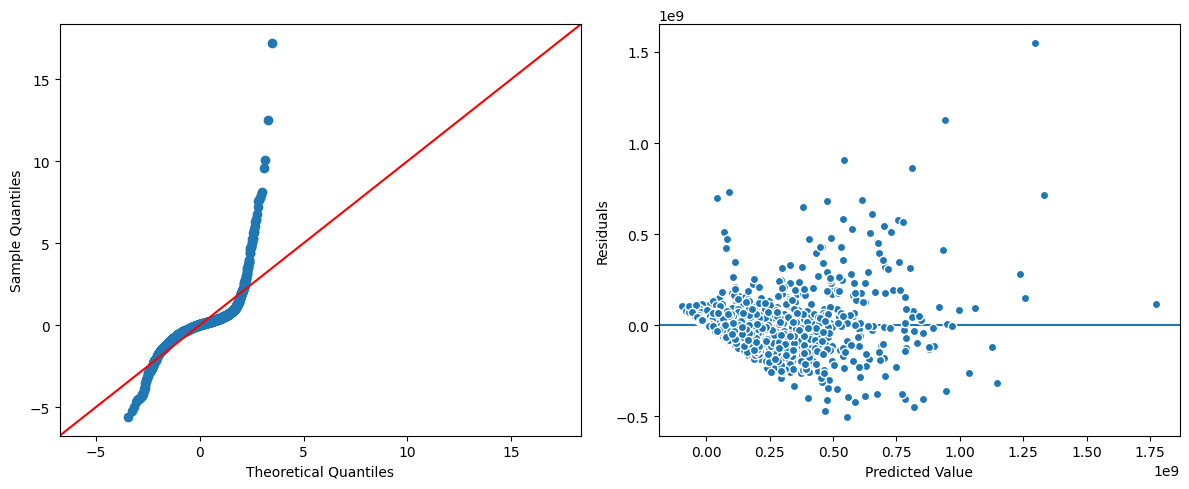

In [58]:
evaluate_ols(result,X_train_df, y_train)

## Checking for Linearity

In [51]:
## concatenating training data into plot_df
plot_df = pd.concat([X_train_df, y_train], axis=1)
plot_df

certification_G  certification_MISSING  certification_NC-17  \
6441               0.0                    0.0                  0.0   
12137              0.0                    0.0                  0.0   
37196              0.0                    0.0                  0.0   
29489              0.0                    0.0                  0.0   
1204               0.0                    0.0                  0.0   
...                ...                    ...                  ...   
1207               0.0                    0.0                  0.0   
9801               0.0                    0.0                  0.0   
33436              0.0                    0.0                  0.0   
21822              0.0                    0.0                  0.0   
39640              0.0                    0.0                  0.0   

       certification_NR  certification_PG  certification_PG-13  \
6441                0.0               0.0                  1.0   
12137               0.0               0.0                  1.0   
37196               0.0               0.0                  0.0   
29489               0.0               0.0                  1.0   
1204                0.0               0.0                  0.0   
...                 ...               ...                  ...   
1207                0.0               0.0                  0.0   
9801                0.0               0.0                  0.0   
33436               0.0               0.0                  0.0   
21822               0.0               0.0                  1.0   
39640               0.0               0.0                  0.0   

       certification_R  adult       budget  popularity  ...  \
6441               0.0    0.0  150000000.0     241.524  ...   
12137              0.0    0.0   25000000.0      67.203  ...   
37196              1.0    0.0    6000000.0      24.783  ...   
29489              0.0    0.0    5000000.0       7.185  ...   
1204               1.0    0.0   35000000.0      33.593  ...   
...                ...    ...          ...         ...  ...   
1207               1.0    0.0   38000000.0      10.498  ...   
9801               1.0    0.0   50000000.0       6.692  ...   
33436              1.0    0.0    6000000.0      25.064  ...   
21822              0.0    0.0   17000000.0      24.734  ...   
39640              1.0    0.0   20000000.0      12.100  ...   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
6441                          0.0                             0.0   
12137                         0.0                             0.0   
37196                         0.0                             0.0   
29489                         0.0                             0.0   
1204                          0.0                             0.0   
...                           ...                             ...   
1207                          0.0                             0.0   
9801                          0.0                             0.0   
33436                         0.0                             0.0   
21822                         0.0                             0.0   
39640                         0.0                             0.0   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
6441                            0.0                          0.0   
12137                           0.0                          0.0   
37196                           0.0                          0.0   
29489                           0.0                          0.0   
1204                            0.0                          0.0   
...                             ...                          ...   
1207                            0.0                          0.0   
9801                            0.0                          0.0   
33436                           0.0                          0.0   
21822                           0.0                          0.0   
39640                           0.0    

In [52]:
## save plot_cols list to show (dropping genre, product companies from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre')]
comp_cols = [i for i in df.columns if i.startswith('ProdComp')]
plot_cols = plot_df.drop(columns=['revenue', *genre_cols, *comp_cols]).columns
len(plot_cols)

18

In [53]:
plot_kws = dict(line_kws = {'color':"red", 'ls':"--"},
                scatter_kws = {'edgecolor':"white", 'lw':1})

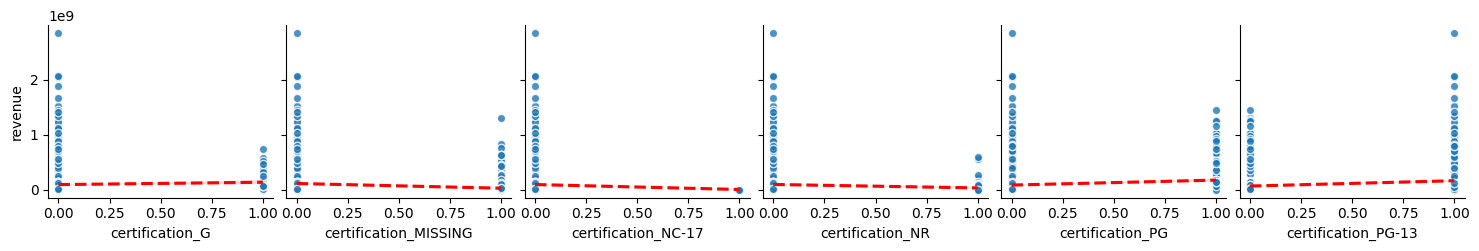

In [54]:
## Plot first 6 features
sns.pairplot(data=plot_df, y_vars='revenue', x_vars=plot_cols[:6], kind='reg', plot_kws=plot_kws)

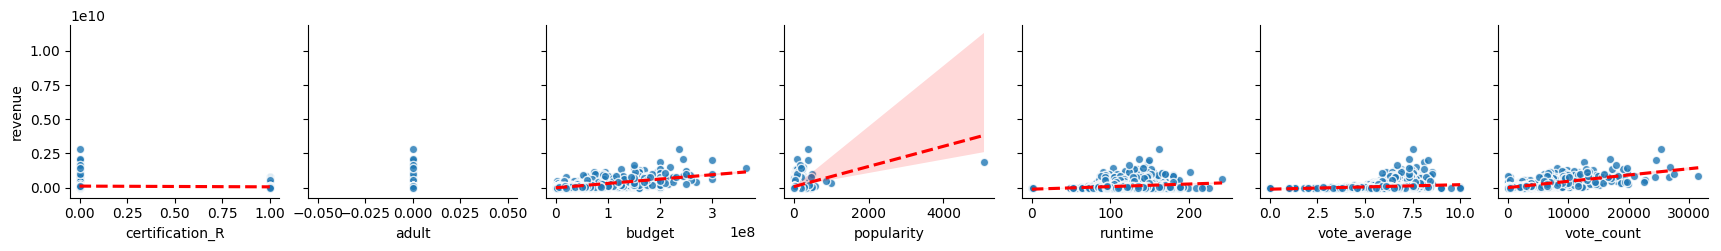

In [55]:
## Plot next 6 features
sns.pairplot(data=plot_df, y_vars='revenue', x_vars=plot_cols[6:13], kind='reg', plot_kws=plot_kws)

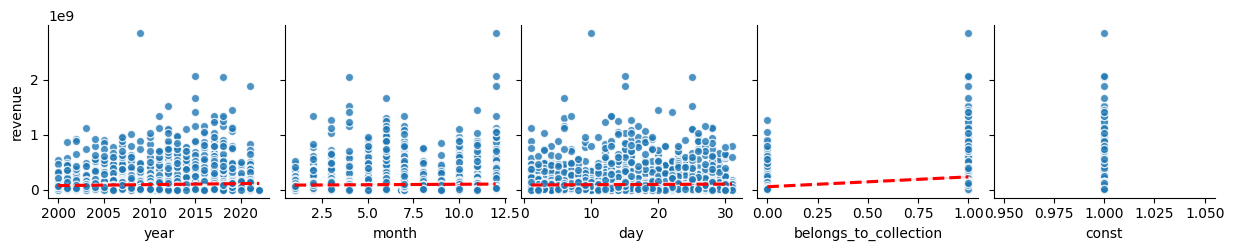

In [56]:
## plot remaining features
sns.pairplot(data=plot_df, y_vars='revenue', x_vars=plot_cols[13:], kind='reg', plot_kws=plot_kws)

From the visuals of the linearity between the feature and our target, we can do some of the things to improve our model.

drop the years before 2000

check ourliers in popularity, runtime

In [59]:
# remove movies prior to 2000
df = df.loc[df['year']>=2000]
df.head()

adult  belongs_to_collection       budget  popularity      revenue  \
3     0.0                  False     150000.0      22.411   12854953.0   
10    0.0                  False     120000.0       5.300      14904.0   
12    0.0                   True   45000000.0      51.339  224834564.0   
15    0.0                  False    8000000.0       8.371     105983.0   
16    0.0                   True  125000000.0      26.731  546388105.0   

    runtime  vote_average  vote_count certification  Genre_Comedy  ...  \
3      99.0           8.1      1868.0            PG         False  ...   
10     87.0           5.5        40.0             R         False  ...   
12     84.0           6.7      3997.0             G          True  ...   
15    122.0           5.9       247.0             R         False  ...   
16    123.0           6.1      5279.0         PG-13         False  ...   

    ProdComp_Summit Entertainment  ProdComp_TF1 Films Production  \
3                           False                          False   
10                          False                          False   
12                          False                          False   
15                          False                          False   
16                          False                          False   

    ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
3                        False                           False   
10                       False                           False   
12                       False                           False   
15                       False                           False   
16                       False                           False   

    ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
3                          False                        False   
10                         False                        False   
12                         False                        False   
15                         False                        False   
16                         False                        False   

    ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
3                                False                          False   
10                               False                          False   
12                               False                          False   
15                               False                          False   
16                               False                          False   

    ProdComp_Warner Bros. Pictures  ProdComp_Working Title Films  
3                            False                         False  
10                           False                         False  
12                           False                         False  
15                           False                         False  
16                           False                         False  

[5 rows x 81 columns]

## Model 2 &3: the evaluation of the model after the improvement: removing outliers 

## Functionize ALL of the preprocessing

In [60]:
def get_train_test_split(df_, y_col='revenue',drop_cols=[]):
    
    ## Make copy of input df
    df = df_.copy()
    
    ## filter columns in drop cols (if exist)
    final_drop_cols = []
    [df.drop(columns=c,inplace=True) for c in df.columns if c in drop_cols]
    
    
    ## Make x and y variables
    y = df[y_col].copy()
    X = df.drop(columns=[y_col]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
    

    
    ## make cat selector and using it to save list of column names
    cat_select = make_column_selector(dtype_include='object')
    cat_cols = cat_select(X_train)


    ## make num selector and using it to save list of column names
    num_select = make_column_selector(dtype_include='number')
    num_cols = num_select(X_train)


    ## select manually OHE cols for later
    bool_select = make_column_selector(dtype_include='bool')
    already_ohe_cols = bool_select(X_train)

    ## convert manual ohe to int
    X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
    X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

    ## make pipelines
    cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                            )

    preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')
    
    

    ## fit the col transformer
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


    ## Create the empty list
    final_features = [*cat_features,*num_cols,*already_ohe_cols]

    ## Make df verisons of x data
    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels
    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
    return X_train_df, y_train, X_test_df, y_test

## Removing Outliers

### Using Z-Score Rule & Using IQR Rule

In [63]:
## Create functions to get outliers from both rules

from scipy import stats
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

def find_outliers_IQR(data, verbose=True):
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using IQR.")
        
    return outliers

In [64]:
## Loop to remove outliers from same clumns using new function
outlier_cols = ['runtime','popularity','revenue']

## Empty dict for both types of outliers
outliers_z = {}
outliers_iqr = {}
## Use both functions to see the comparison for # of outliers
for col in outlier_cols:
    outliers_col_z = find_outliers(df[col])
    outliers_z[col] = outliers_col_z
    
    outliers_col_iqr = find_outliers_IQR(df[col])
    outliers_iqr[col] = outliers_col_iqr
    print()

- 0 outliers found in runtime using Z-Scores.
- 0 outliers found in runtime using IQR.

- 34 outliers found in popularity using Z-Scores.
- 518 outliers found in popularity using IQR.

- 128 outliers found in revenue using Z-Scores.
- 540 outliers found in revenue using IQR.



In [65]:
# remove_outliers - create df_clean_z
df_clean_z = df.copy()

## loop though outliers_z
for col, idx_outliers in outliers_z .items():
    df_clean_z = df_clean_z[~idx_outliers]
df_clean_z.head(2)

C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\794806485.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_z = df_clean_z[~idx_outliers]


adult  belongs_to_collection    budget  popularity     revenue  runtime  \
3     0.0                  False  150000.0      22.411  12854953.0     99.0   
10    0.0                  False  120000.0       5.300     14904.0     87.0   

    vote_average  vote_count certification  Genre_Comedy  ...  \
3            8.1      1868.0            PG         False  ...   
10           5.5        40.0             R         False  ...   

    ProdComp_Summit Entertainment  ProdComp_TF1 Films Production  \
3                           False                          False   
10                          False                          False   

    ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
3                        False                           False   
10                       False                           False   

    ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
3                          False                        False   
10                         False                        False   

    ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
3                                False                          False   
10                               False                          False   

    ProdComp_Warner Bros. Pictures  ProdComp_Working Title Films  
3                            False                         False  
10                           False                         False  

[2 rows x 81 columns]

In [66]:
# remove_outliers  to create df_clean_iqr
df_clean_iqr = df.copy()

## Loop to remove
for col, idx_outliers in outliers_iqr .items():
    df_clean_iqr = df_clean_z[~idx_outliers]
df_clean_iqr.head(2)

C:\Users\qfu88\AppData\Local\Temp\ipykernel_18356\1841345331.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_iqr = df_clean_z[~idx_outliers]


adult  belongs_to_collection    budget  popularity     revenue  runtime  \
3     0.0                  False  150000.0      22.411  12854953.0     99.0   
10    0.0                  False  120000.0       5.300     14904.0     87.0   

    vote_average  vote_count certification  Genre_Comedy  ...  \
3            8.1      1868.0            PG         False  ...   
10           5.5        40.0             R         False  ...   

    ProdComp_Summit Entertainment  ProdComp_TF1 Films Production  \
3                           False                          False   
10                          False                          False   

    ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
3                        False                           False   
10                       False                           False   

    ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
3                          False                        False   
10                         False                        False   

    ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
3                                False                          False   
10                               False                          False   

    ProdComp_Warner Bros. Pictures  ProdComp_Working Title Films  
3                            False                         False  
10                           False                         False  

[2 rows x 81 columns]

### Model 2: Using outliers (z score rule)removed data 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     143.9
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:11:08   Log-Likelihood:                -70956.
No. Observations:                3696   AIC:                         1.421e+05
Df Residuals:                    3612   BIC:                         1.426e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                    -1.854e+06   5.34e+07     -0.035      0.972   -1.07e+08    1.03e+08
certification_MISSING                  1.2372      0.038     32.466      0.000       1.162       1.312
certification_NC-17                 1.235e+05   3.85e+04      3.208      0.001     4.8e+04    1.99e+05
certification_NR                     9.18e+04   4.99e+04      1.840      0.066   -5998.423     1.9e+05
certification_PG                   -6.967e+05   8.54e+05     -0.816      0.414   -2.37e+06    9.77e+05
certification_PG-13                 2.198e+04    504.715     43.547      0.000     2.1e+04     2.3e+04
certification_R                    -3.387e+05   1.73e+05     -1.952      0.051   -6.79e+05    1440.149
adult                              -1.035e+05    2.6e+05     -0.399      0.690   -6.12e+05    4.05e+05
budget                             -9.209e+04   1.04e+05     -0.886      0.376   -2.96e+05    1.12e+05
popularity                          1.001e+08   4.38e+07      2.285      0.022    1.42e+07    1.86e+08
runtime                             8.675e+07    4.4e+07      1.973      0.049    5.27e+05    1.73e+08
vote_average                        7.394e+07   4.64e+07      1.595      0.111    -1.7e+07    1.65e+08
vote_count                          8.257e+07   4.41e+07      1.874      0.061    -3.8e+06    1.69e+08
year                                9.269e+07   4.37e+07      2.121      0.034    7.01e+06    1.78e+08
month                                8.12e+07   4.36e+07      1.861      0.063   -4.34e+06    1.67e+08
day                                 6.888e+07   4.36e+07      1.580      0.114   -1.66e+07    1.54e+08
belongs_to_collection               3.387e+07   2.44e+06     13.872      0.000    2.91e+07    3.87e+07
Genre_Comedy                        6.033e+06   2.31e+06      2.612      0.009    1.51e+06    1.06e+07
Genre_Music                         9.218e+06   5.49e+06      1.680      0.093   -1.54e+06       2e+07
Genre_Romance                       5.835e+06   2.55e+06      2.291      0.022    8.42e+05    1.08e+07
Genre_Science Fiction              -2.363e+07   3.37e+06     -7.009      0.000   -3.02e+07    -1.7e+07
Genre_Drama                         -2.62e+06   2.31e+06     -1.135      0.256   -7.15e+06    1.91e+06
Genre_Action                       -2.047e+06   2.52e+06     -0.813      0.417   -6.99e+06    2.89e+06
Genre_Crime                         -7.33e+06   2.82e+06     -2.604      0.009   -1.28e+07   -1.81e+06
Genre_Adventure                    -2.267e+06   2.97e+06     -0.763      0.446   -8.09e+06    3.56e+06
Genre_Animation                     7.933e+06   4.96e+06      1.598      0.110    -1.8e+06    1.77e+07
Genre_Fantasy                      -8.379e+06   3.37e+06     -2.489      0.013    -1.5e+07   -1.

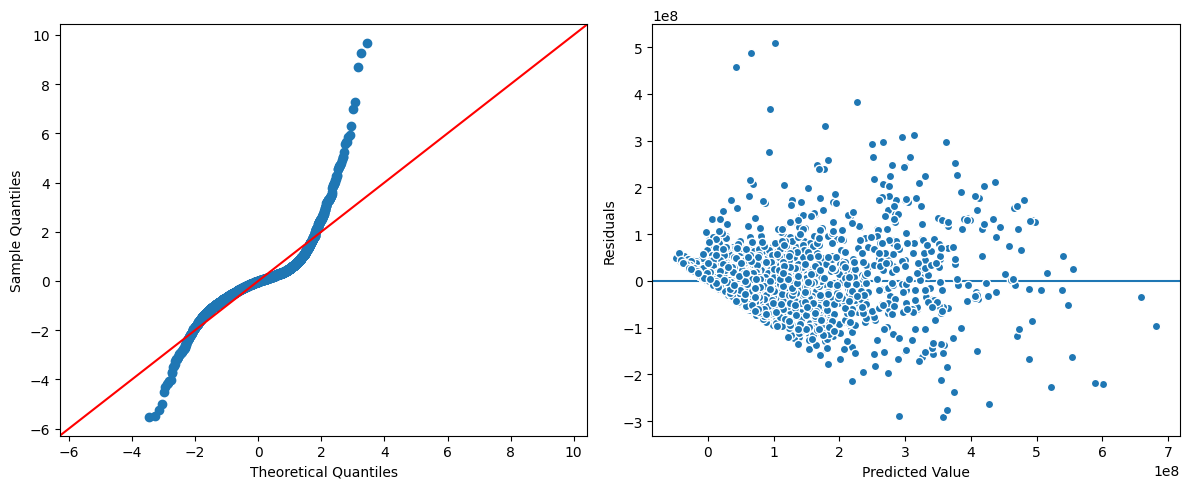

In [67]:
## MAKE NEW MODEL WITH zscores OUTLIERS REMOVED
## Use our function to make new x,y vars
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_z)


## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)
## Fit the model and view the summary
result = model.fit()
evaluate_ols(result, X_train_df, y_train)

### Model 3: Using outliers (IRQ rule)removed data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     77.94
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:12:53   Log-Likelihood:                -63403.
No. Observations:                3393   AIC:                         1.270e+05
Df Residuals:                    3309   BIC:                         1.275e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                    -3.868e+06    3.2e+07     -0.121      0.904   -6.67e+07     5.9e+07
certification_MISSING                  0.7147      0.030     24.044      0.000       0.656       0.773
certification_NC-17                 1.101e+05   2.86e+04      3.845      0.000    5.39e+04    1.66e+05
certification_NR                    1.121e+05   3.16e+04      3.546      0.000    5.01e+04    1.74e+05
certification_PG                     5.78e+05   5.41e+05      1.069      0.285   -4.82e+05    1.64e+06
certification_PG-13                 1.329e+04    423.590     31.379      0.000    1.25e+04    1.41e+04
certification_R                    -3.489e+05    1.1e+05     -3.173      0.002   -5.64e+05   -1.33e+05
adult                              -2.565e+04   1.62e+05     -0.158      0.874   -3.44e+05    2.92e+05
budget                              6.591e+04   6.45e+04      1.021      0.307   -6.06e+04    1.92e+05
popularity                          9.619e+07   2.77e+07      3.468      0.001    4.18e+07    1.51e+08
runtime                             8.389e+07   2.79e+07      3.009      0.003    2.92e+07    1.39e+08
vote_average                        8.134e+07    2.9e+07      2.804      0.005    2.45e+07    1.38e+08
vote_count                          8.554e+07   2.79e+07      3.071      0.002    3.09e+07     1.4e+08
year                                9.263e+07   2.77e+07      3.341      0.001    3.83e+07    1.47e+08
month                               8.783e+07   2.77e+07      3.174      0.002    3.36e+07    1.42e+08
day                                 7.634e+07   2.76e+07      2.761      0.006    2.21e+07    1.31e+08
belongs_to_collection               1.856e+07   1.61e+06     11.505      0.000    1.54e+07    2.17e+07
Genre_Comedy                        3.747e+06   1.44e+06      2.605      0.009    9.27e+05    6.57e+06
Genre_Music                         5.517e+06   3.51e+06      1.570      0.117   -1.37e+06    1.24e+07
Genre_Romance                       1.314e+06   1.56e+06      0.844      0.398   -1.74e+06    4.36e+06
Genre_Science Fiction               -1.64e+07   2.21e+06     -7.406      0.000   -2.07e+07   -1.21e+07
Genre_Drama                        -5.273e+06   1.43e+06     -3.689      0.000   -8.08e+06   -2.47e+06
Genre_Action                       -3.549e+05   1.56e+06     -0.228      0.820   -3.41e+06     2.7e+06
Genre_Crime                        -1.465e+06   1.76e+06     -0.834      0.404   -4.91e+06    1.98e+06
Genre_Adventure                    -4.224e+06   1.95e+06     -2.162      0.031   -8.06e+06   -3.93e+05
Genre_Animation                    -2.433e+06   3.31e+06     -0.734      0.463   -8.93e+06    4.06e+06
Genre_Fantasy                      -7.114e+06   2.15e+06     -3.307      0.001   -1.13e+07    -2

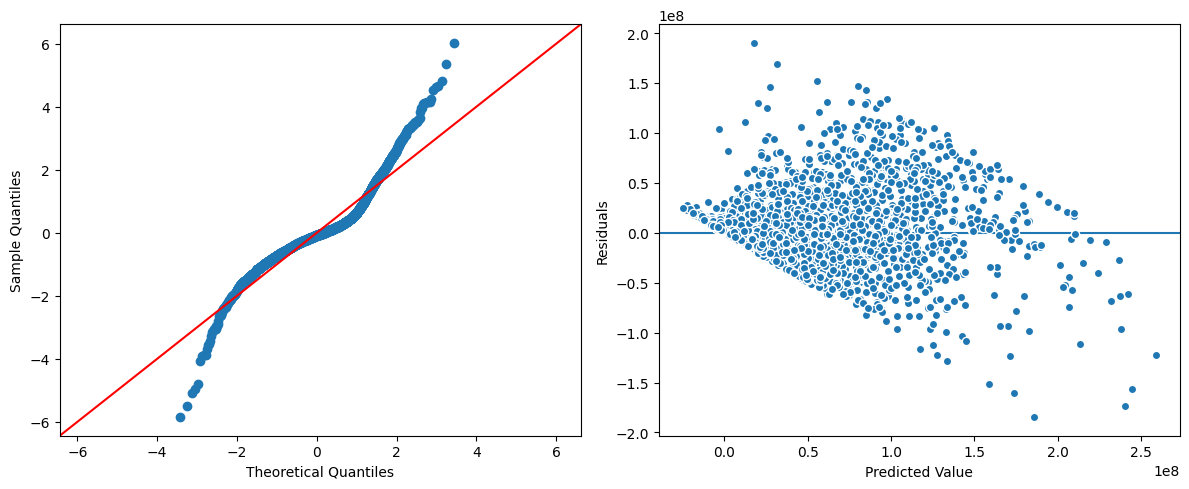

In [68]:
## MAKE NEW MODEL WITH IQR OUTLIERS REMOVED
## Use our function to make new x,y vars
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_iqr)


## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)
## Fit the model and view the summary
result = model.fit()
evaluate_ols(result, X_train_df, y_train)

## Removing more features-based on p-values

In [69]:
## get pvalues from model result
pvals = result.pvalues
pvals

certification_G                        9.039333e-01
certification_MISSING                 7.199156e-118
certification_NC-17                    1.227667e-04
certification_NR                       3.966097e-04
certification_PG                       2.853055e-01
                                          ...      
ProdComp_Village Roadshow Pictures     1.488879e-01
ProdComp_Walt Disney Pictures          4.719747e-05
ProdComp_Warner Bros. Pictures         2.381431e-03
ProdComp_Working Title Films           1.528899e-01
const                                  1.806746e-03
Length: 87, dtype: float64

In [70]:
## Check for p-values that are >.05
pvals[pvals>.05]

certification_G                       0.903933
certification_PG                      0.285305
adult                                 0.874355
budget                                0.307146
Genre_Music                           0.116515
Genre_Romance                         0.398498
Genre_Action                          0.819623
Genre_Crime                           0.404217
Genre_Animation                       0.462848
Genre_Horror                          0.239528
Genre_Thriller                        0.537702
Genre_History                         0.664649
Genre_Family                          0.191431
Genre_Mystery                         0.824417
Genre_War                             0.949136
Genre_TV Movie                        0.631305
Genre_Documentary                     0.576145
ProdComp_BBC Films                    0.675611
ProdComp_Blumhouse Productions        0.065141
ProdComp_CJ Entertainment             0.249878
ProdComp_Canal+                       0.892816
ProdComp_Ciné

In [71]:
## Get list of ALL genre columns to see how many are sig
genre_cols = [c for c in df_clean_iqr.columns if c.startswith('Genre')]
genre_cols

['Genre_Comedy',
 'Genre_Music',
 'Genre_Romance',
 'Genre_Science Fiction',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Crime',
 'Genre_Adventure',
 'Genre_Animation',
 'Genre_Fantasy',
 'Genre_Horror',
 'Genre_Thriller',
 'Genre_History',
 'Genre_Family',
 'Genre_Mystery',
 'Genre_Western',
 'Genre_War',
 'Genre_TV Movie',
 'Genre_Documentary']

In [72]:
## save just genre pvalues
genre_pvals = pvals[genre_cols]
## calc what % are insig?
genre_pvals.sum()/len(genre_pvals)

0.36122603178098694

In [73]:
## Get list of ALL prod_comp columns to see how many are sig
comp_cols = [c for c in df_clean_iqr.columns if c.startswith('ProdComp')]
comp_cols

['ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Animation',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Legendary Pictures',
 'ProdComp_Lionsgate',
 'ProdComp_MISSING',
 'ProdComp_Metro-Goldwyn-Mayer',
 'ProdComp_Millennium Films',
 'ProdComp_Miramax',
 'ProdComp_New Line Cinema',
 'ProdComp_New Regency Pictures',
 'ProdComp_Original Film',
 'ProdComp_Paramount',
 'ProdComp_Participant',
 'ProdComp_Regency Enterprises',
 'ProdComp_Relativity Media',
 'ProdComp_Revolution Studios',
 'ProdComp_Scot

In [74]:
## save just comp pvalues
comp_pvals = pvals[comp_cols]
## calc what % are insig?
comp_pvals.sum()/len(comp_pvals)

0.2856942750213651

both have <50% bad pvalues. Keep both!

In [77]:
## what pvals are remaining?
othe_pvals = pvals.drop([*comp_cols, *genre_cols])
othe_pvals[othe_pvals>.05]

certification_G     0.903933
certification_PG    0.285305
adult               0.874355
budget              0.307146
dtype: float64

### Model 4: Using data after removing the features with bad pvalues

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     59.84
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:19:50   Log-Likelihood:                -63714.
No. Observations:                3393   AIC:                         1.276e+05
Df Residuals:                    3311   BIC:                         1.281e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                     1.725e+05   3.01e+04      5.724      0.000    1.13e+05    2.32e+05
certification_MISSING               2.766e+05   3.45e+04      8.013      0.000    2.09e+05    3.44e+05
certification_NC-17                -7.264e+05   5.79e+05     -1.255      0.210   -1.86e+06    4.09e+05
certification_NR                    1.485e+04    452.304     32.830      0.000     1.4e+04    1.57e+04
certification_PG                   -4.105e+05    1.2e+05     -3.409      0.001   -6.47e+05   -1.74e+05
certification_PG-13                -3.413e+04   1.77e+05     -0.193      0.847   -3.82e+05    3.13e+05
certification_R                     3.684e+04   7.06e+04      0.522      0.602   -1.02e+05    1.75e+05
popularity                          1.093e+08   3.04e+07      3.590      0.000    4.96e+07    1.69e+08
runtime                             9.412e+07   3.06e+07      3.081      0.002    3.42e+07    1.54e+08
vote_average                        9.722e+07   3.18e+07      3.053      0.002    3.48e+07     1.6e+08
vote_count                          9.682e+07   3.05e+07      3.170      0.002    3.69e+07    1.57e+08
year                                1.106e+08   3.03e+07      3.652      0.000    5.12e+07     1.7e+08
month                               1.076e+08   3.03e+07      3.554      0.000    4.82e+07    1.67e+08
day                                 9.267e+07   3.03e+07      3.060      0.002    3.33e+07    1.52e+08
belongs_to_collection               1.879e+07   1.76e+06     10.673      0.000    1.53e+07    2.22e+07
Genre_Comedy                        6.004e+06   1.59e+06      3.786      0.000    2.89e+06    9.11e+06
Genre_Music                         4.906e+06   3.67e+06      1.336      0.182    -2.3e+06    1.21e+07
Genre_Romance                      -1.981e+04   1.71e+06     -0.012      0.991   -3.37e+06    3.33e+06
Genre_Science Fiction              -1.121e+07   2.42e+06     -4.626      0.000    -1.6e+07   -6.46e+06
Genre_Drama                        -8.039e+06   1.56e+06     -5.154      0.000   -1.11e+07   -4.98e+06
Genre_Action                        3.668e+06   1.69e+06      2.174      0.030     3.6e+05    6.98e+06
Genre_Crime                        -1.468e+06    1.9e+06     -0.774      0.439   -5.19e+06    2.25e+06
Genre_Adventure                     1.672e+06   2.12e+06      0.790      0.430   -2.48e+06    5.82e+06
Genre_Animation                     5.666e+06   3.61e+06      1.571      0.116   -1.41e+06    1.27e+07
Genre_Fantasy                      -2.228e+05   2.37e+06     -0.094      0.925   -4.86e+06    4.42e+06
Genre_Horror                       -6.902e+05   2.27e+06     -0.304      0.761   -5.14e+06    3.76e+06
Genre_Thriller                      1.745e+06   1.69e+06      1.034      0.301   -1.56e+06    5.

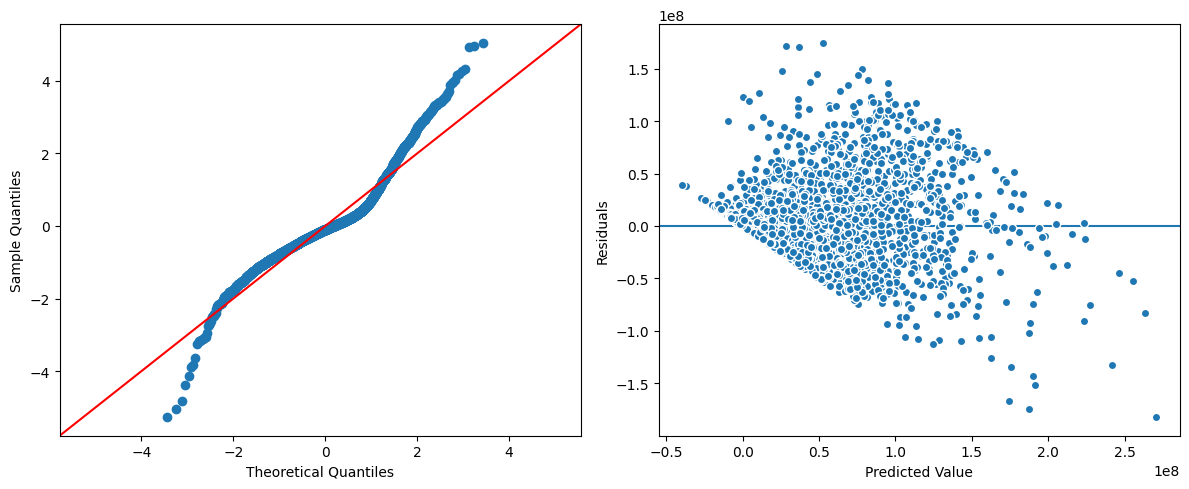

In [76]:
## Make x,y vars, but drop features with bad pvalues
df_clean_iqr = df_clean_iqr.drop(columns = ['adult', 'budget'])

X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_iqr)
## MAKE AND EVALUATE OLS
model = sm.OLS(y_train, X_train_df)
result = model.fit()
evaluate_ols(result, X_train_df, y_train)

## Addressing Multicollinearity

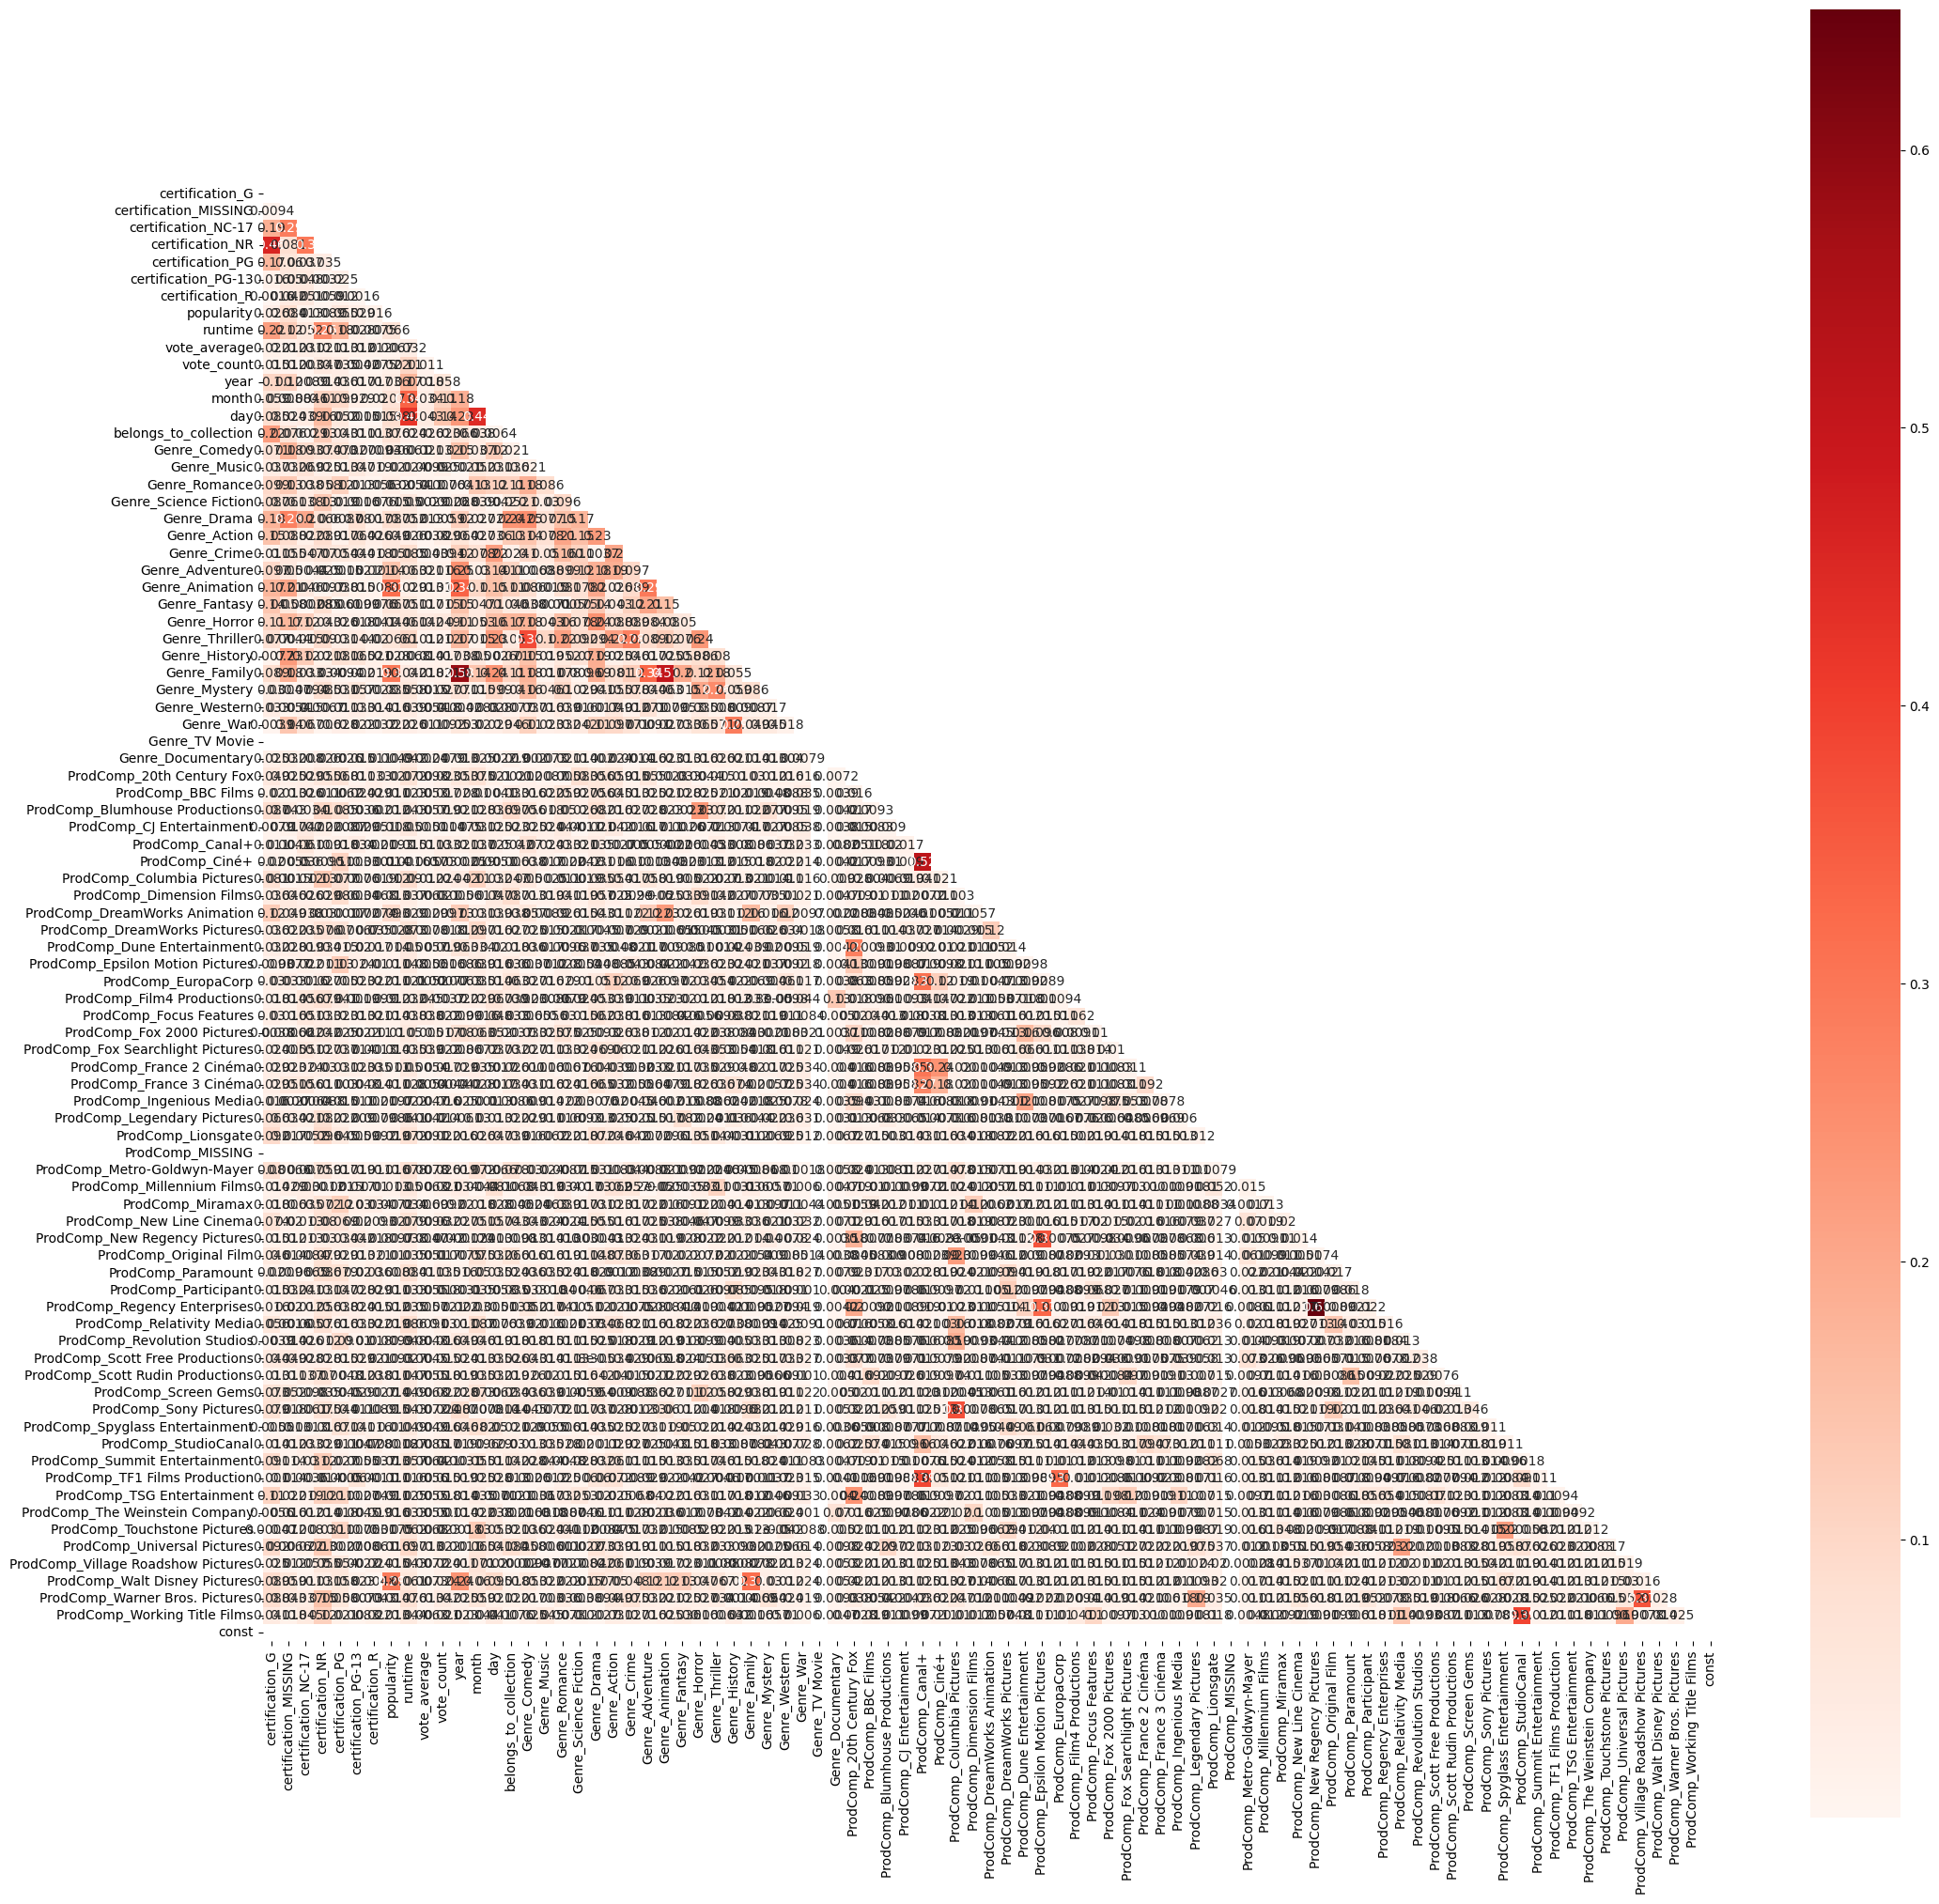

In [78]:
## Calculating the mask to hide the upper-right of the triangle
corr = X_train_df.corr().abs()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(25,25))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

### Variance Inflation Factor

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
# separate just x-data and subtract mean
features = X_train_df - X_train_df.mean()
features

certification_G  certification_MISSING  certification_NC-17  \
1670         -9.471657             -19.269083            -0.425582   
16467         0.157343              -9.269083            -0.525582   
28273       -11.170657               6.730917             0.474418   
53407       -18.370657              44.730917             0.574418   
25377        -8.837657               7.730917             0.674418   
...                ...                    ...                  ...   
41814        -9.554657             -18.269083            -0.325582   
7005         -3.981657             -23.269083             0.074418   
12202        -4.982657             -17.269083            -0.325582   
297         -11.480657             -12.269083            -0.225582   
45539       -10.639657              -6.269083            -0.625582   

       certification_NR  certification_PG  certification_PG-13  \
1670       -1060.937813         -9.314471             4.259063   
16467       -335.937813         -0.314471             4.259063   
28273       -462.937813          4.685529             2.259063   
53407      -1191.937813          9.685529            -5.740937   
25377       -599.937813          2.685529             5.259063   
...                 ...               ...                  ...   
41814       -898.937813          6.685529            -5.740937   
7005         257.062187         -5.314471             1.259063   
12202       -335.937813         -2.314471            -2.740937   
297        -1059.937813        -10.314471            -3.740937   
45539      -1109.937813          7.685529             4.259063   

       certification_R  popularity   runtime  vote_average  ...  \
1670          5.785146   -0.013557 -0.241969     -0.003242  ...   
16467        -9.214854   -0.013557 -0.241969     -0.003242  ...   
28273         0.785146   -0.013557 -0.241969     -0.003242  ...   
53407        15.785146   -0.013557  0.758031     -0.003242  ...   
25377       -13.214854   -0.013557 -0.241969     -0.003242  ...   
...                ...         ...       ...           ...  ...   
41814         3.785146   -0.013557  0.758031     -0.003242  ...   
7005          3.785146   -0.013557 -0.241969     -0.003242  ...   
12202       -13.214854   -0.013557 -0.241969     -0.003242  ...   
297           8.785146   -0.013557 -0.241969     -0.003242  ...   
45539         0.785146   -0.013557 -0.241969     -0.003242  ...   

       ProdComp_TF1 Films Production  ProdComp_TSG Entertainment  \
1670                       -0.009431                   -0.009136   
16467                      -0.009431                   -0.009136   
28273                      -0.009431                   -0.009136   
53407                      -0.009431                   -0.009136   
25377                      -0.009431                   -0.009136   
...                              ...                         ...   
41814                      -0.009431                   -0.009136   
7005                       -0.009431                   -0.009136   
12202                      -0.009431                   -0.009136   
297                        -0.009431                   -0.009136   
45539                      -0.009431                   -0.009136   

       ProdComp_The Weinstein Company  ProdComp_Touchstone Pictures  \
1670                        -0.009136                      0.985853   
16467                       -0.009136                     -0.014147   
28273                       -0.009136                     -0.014147   
53407                       -0.009136                     -0.014147   
25377                       -0.009136                     -0.014147   
...                               ...                           ...   
41814                       -0.009136                     -0.014147   
7005                        -0.009136                     -0.014147   
12202                       -0.009136                     -0.014147   
297                         -0.009136    

In [80]:
# create a list of VIF scores for each feature in features.
vif_scores = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
# create a new dataframe to hold the VIF scores 
VIF = pd.Series(vif_scores, index = features.columns)
VIF.sort_values()

C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


certification_R                   1.023315
ProdComp_CJ Entertainment         1.023729
ProdComp_The Weinstein Company    1.031668
Genre_Documentary                 1.034497
ProdComp_BBC Films                1.039967
                                    ...   
runtime                                inf
popularity                             inf
Genre_TV Movie                         NaN
ProdComp_MISSING                       NaN
const                                  NaN
Length: 85, dtype: float64

In [81]:
## Set float format to view vals not in scientfic notation
pd.set_option('display.float_format', lambda x: f'{x: .2f}')

In [82]:
## remove infinite values from VIF and sort
VIF = VIF[VIF!=np.inf].sort_values()
VIF

certification_R                   1.02
ProdComp_CJ Entertainment         1.02
ProdComp_The Weinstein Company    1.03
Genre_Documentary                 1.03
ProdComp_BBC Films                1.04
                                  ... 
ProdComp_Canal+                   2.01
Genre_Family                      2.22
Genre_TV Movie                     NaN
ProdComp_MISSING                   NaN
const                              NaN
Length: 78, dtype: float64

In [83]:
## filter for VIF that are > 5
VIF[VIF>5]

Series([], dtype: float64)

In [84]:
## save name of features with high vif
high_vif = VIF[VIF>5].index
high_vif

Index([], dtype='object')

### Model 5(final model): using data after removing the high VIF 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     60.46
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:26:22   Log-Likelihood:                -63712.
No. Observations:                3393   AIC:                         1.276e+05
Df Residuals:                    3311   BIC:                         1.281e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                     2.175e+05   3.06e+04      7.109      0.000    1.58e+05    2.78e+05
certification_MISSING               2.571e+05   3.33e+04      7.723      0.000    1.92e+05    3.22e+05
certification_NC-17                -6.552e+05   5.68e+05     -1.153      0.249   -1.77e+06    4.59e+05
certification_NR                    1.516e+04    459.300     33.017      0.000    1.43e+04    1.61e+04
certification_PG                   -4.196e+05   1.19e+05     -3.525      0.000   -6.53e+05   -1.86e+05
certification_PG-13                 8411.9494   1.78e+05      0.047      0.962    -3.4e+05    3.57e+05
certification_R                     1.528e+04   7.09e+04      0.216      0.829   -1.24e+05    1.54e+05
popularity                          1.122e+08      3e+07      3.733      0.000    5.33e+07    1.71e+08
runtime                             9.818e+07   3.02e+07      3.251      0.001     3.9e+07    1.57e+08
vote_average                        9.414e+07   3.13e+07      3.011      0.003    3.28e+07    1.55e+08
vote_count                          9.997e+07   3.02e+07      3.308      0.001    4.07e+07    1.59e+08
year                                1.137e+08      3e+07      3.793      0.000    5.49e+07    1.72e+08
month                               1.114e+08   2.99e+07      3.722      0.000    5.27e+07     1.7e+08
day                                 9.513e+07   2.99e+07      3.178      0.001    3.64e+07    1.54e+08
belongs_to_collection               1.543e+07   1.74e+06      8.855      0.000     1.2e+07    1.88e+07
Genre_Comedy                        6.316e+06   1.58e+06      3.989      0.000    3.21e+06    9.42e+06
Genre_Music                         2.268e+06   3.67e+06      0.618      0.537   -4.93e+06    9.47e+06
Genre_Romance                       1.253e+06   1.73e+06      0.725      0.468   -2.13e+06    4.64e+06
Genre_Science Fiction              -1.067e+07   2.51e+06     -4.244      0.000   -1.56e+07   -5.74e+06
Genre_Drama                        -7.584e+06   1.55e+06     -4.904      0.000   -1.06e+07   -4.55e+06
Genre_Action                        3.557e+06    1.7e+06      2.098      0.036    2.32e+05    6.88e+06
Genre_Crime                        -2.359e+05   1.91e+06     -0.123      0.902   -3.98e+06    3.51e+06
Genre_Adventure                     3.344e+06    2.1e+06      1.595      0.111   -7.67e+05    7.45e+06
Genre_Animation                     2.566e+06   3.51e+06      0.732      0.464   -4.31e+06    9.44e+06
Genre_Fantasy                       1.749e+06   2.37e+06      0.738      0.461    -2.9e+06     6.4e+06
Genre_Horror                       -1.213e+06   2.29e+06     -0.530      0.596    -5.7e+06    3.27e+06
Genre_Thriller                      1.409e+06   1.68e+06      0.837      0.403   -1.89e+06    4.

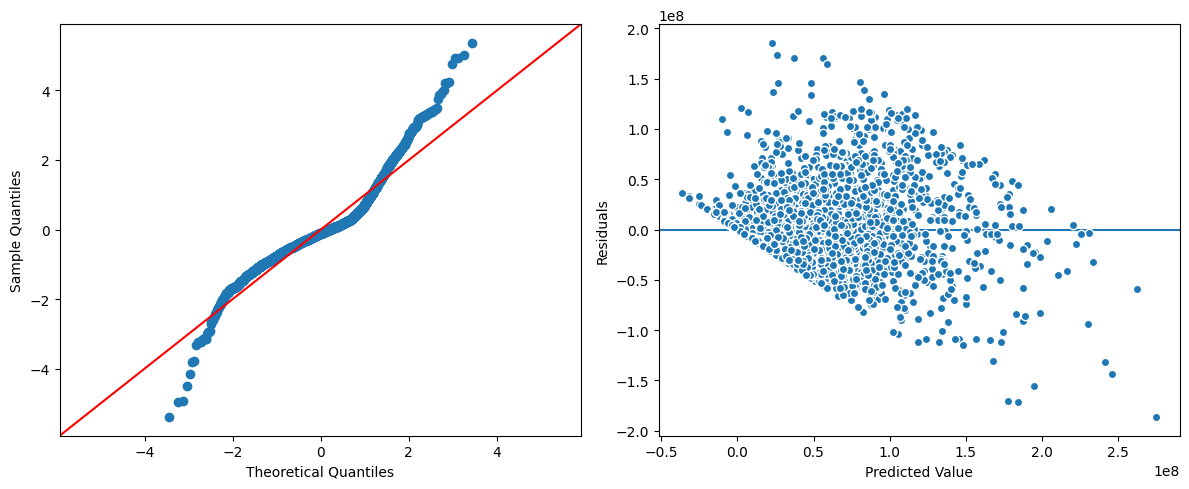

In [85]:
## make new df_final copy of prev df
df_final = df_clean_iqr.drop(columns = high_vif).copy()
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_final)
## FIT AND EVAL OLS
model = sm.OLS(y_train, X_train_df)
result = model.fit()
evaluate_ols(result, X_train_df, y_train)

In [86]:
## Get the score result from sklearn to check if matches OLS

y_hat_train = result.predict(X_train_df)
print(f'Training R2 score: {r2_score(y_train, y_hat_train): .3f}')

y_hat_test = result.predict(X_test_df)
print(f'Testing R2 score: {r2_score(y_test, y_hat_test): .3f}')

Training R2 score:  0.597
Testing R2 score:  0.561


### Visualize Coefficients

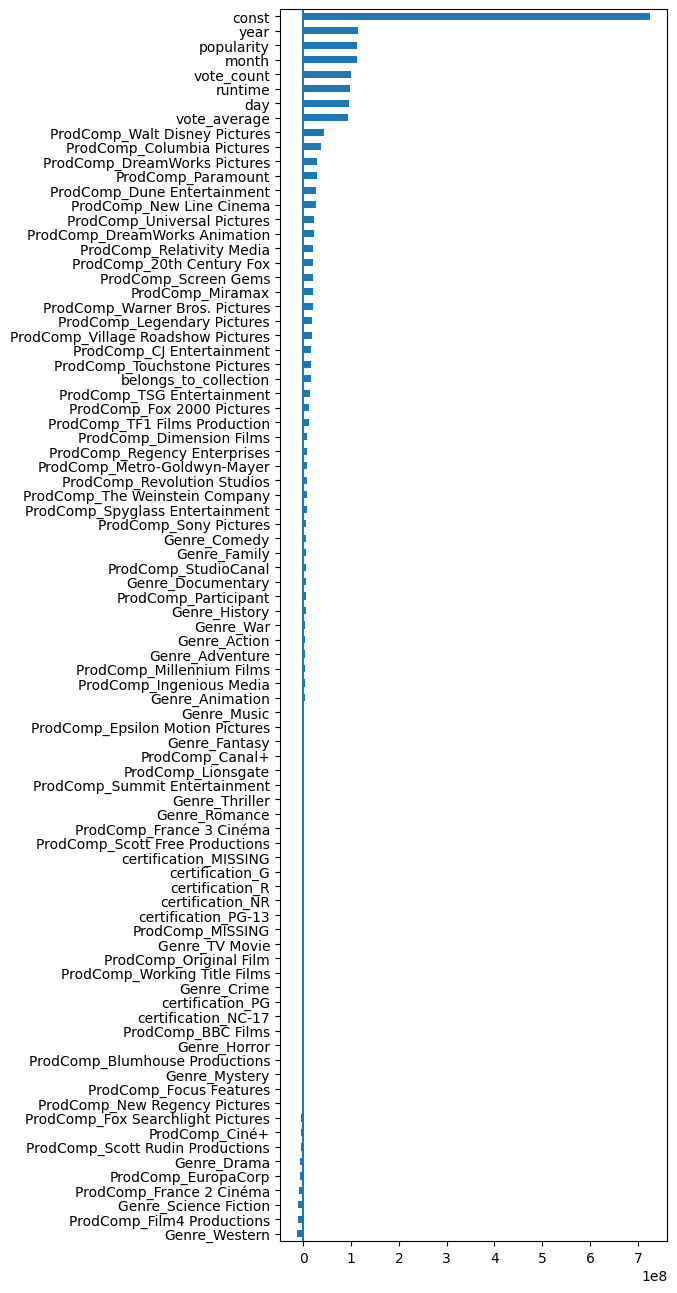

In [87]:
plt.figure(figsize=(5,16))
ax = result.params.sort_values().plot(kind='barh')
ax.axvline()

# Compare to Alternative Regressor: RandomForestRegressor 

## Model 6: RandomForestRegressor model: using the data before checking the assumptions

In [88]:
from sklearn.ensemble import RandomForestRegressor
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)

reg = RandomForestRegressor(verbose=1,random_state=42)
reg.fit(X_train_df, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


RandomForestRegressor(random_state=42, verbose=1)

In [89]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = reg.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = reg.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.970
Testing R^2: 0.805


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


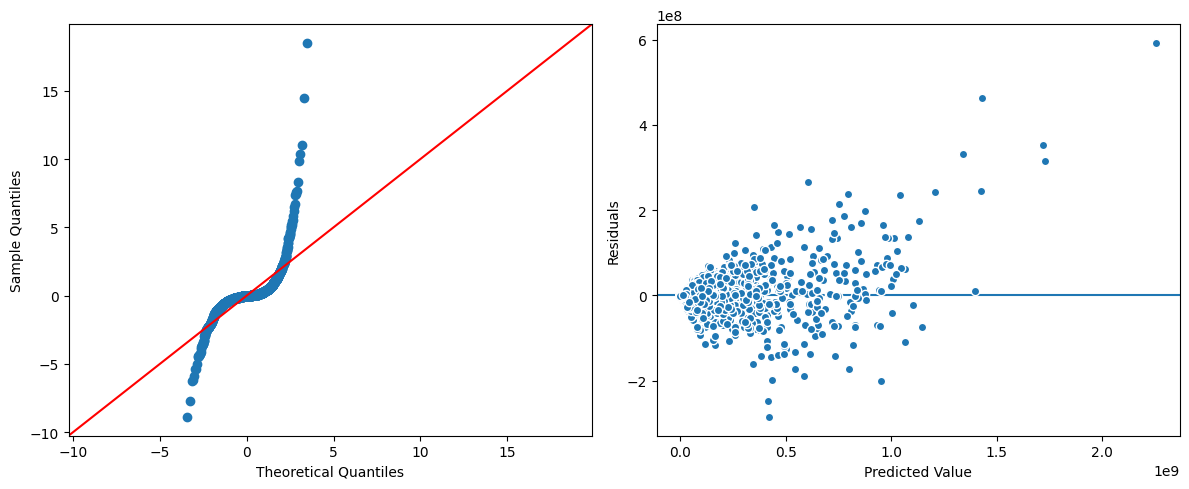

In [90]:
evaluate_ols(reg, X_train_df, y_train)

<AxesSubplot:>

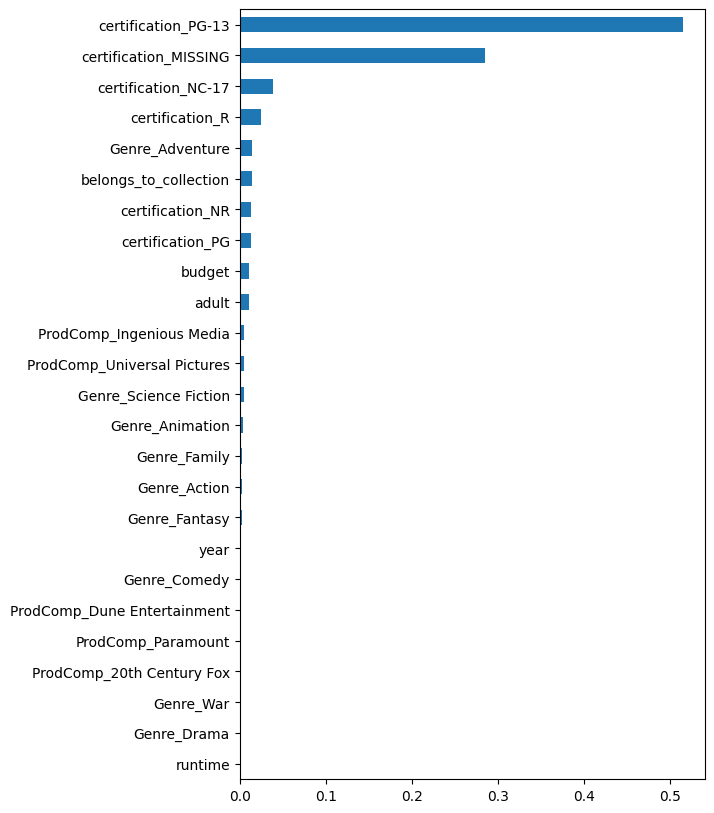

In [91]:
importances = pd.Series(reg.feature_importances_, index=X_train_df.columns)
importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))